#set-ups

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd



[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
import time
import numpy as np

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Loading Price Data

In [4]:
start_date ='2015-01-01'
end_date = '2021-05-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [23]:
import pickle

# Path to your .pkl file
file_path = 'data_elon.pkl'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the dictionary back from the pickle file
    btc_sentiment_data = pickle.load(file)

print(btc_sentiment_data.values())

dict_values([['0'], ['0'], ['Neutral'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0 (neutral)'], ['0'], ['0'], ['0'], ['1'], ['I cannot accurately determine the sentiment of the given tweet as it does not contain any information about Bitcoin or its price.'], ['0'], ['0'], ['0 (neutral)'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['I am sorry, I cannot access the internet. Consequently, I am unable to provide you with a sentiment score for the tweet at the given URL.'], ['0 (neutral)'], ['0'], ['0 (neutral)'], ['-1'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['1'], ['0'], ['0 (neutral)'], ['0'], ['0'], ['Neutral (0)'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ['0'], ["I apologize, but I do not have the ability to access the internet and cannot provide you with a sentiment score for the provided tweet based on its potential impact on the next day's Bitcoin p

In [24]:
type(btc_sentiment_data.values())

dict_values

In [27]:
import re


# Function to extract and clean sentiment values
def clean_sentiment(value):
    # Search for numeric patterns, potentially surrounded by other text
    match = re.search(r'[-\+]?\d', value)
    if match:
        num = int(match.group(0))
        # Check if the number is one of the valid sentiment scores
        if num in [-1, 0, 1]:
            return num
    return None  # Return None or some default value if no valid number is found

# Clean the dictionary
cleaned_data = {}
l = []
for key, value in btc_sentiment_data.items():
    try:
        cleaned_value = clean_sentiment(value[0])
        if cleaned_value is not None:
            cleaned_data[key] = cleaned_value
            # print(cleaned_data)
            # break
        else:
            print(key,value)
    except Exception as e:
        print(e,value)
        l.append[value]
    

# print(cleaned_data)


2021-04-09 ['Neutral']
2021-03-11 ['I cannot accurately determine the sentiment of the given tweet as it does not contain any information about Bitcoin or its price.']
2021-02-26 ['I am sorry, I cannot access the internet. Consequently, I am unable to provide you with a sentiment score for the tweet at the given URL.']
2021-01-31 ["I apologize, but I do not have the ability to access the internet and cannot provide you with a sentiment score for the provided tweet based on its potential impact on the next day's Bitcoin price."]
2021-01-02 ['It is not possible to determine the sentiment of the tweet "@Gfilche 😉" without more context. The tweet is too short and does not provide any information about the user\'s opinion on Bitcoin.\n\nHowever, if the tweet is interpreted as a positive sign, such as a celebrity endorsement or a positive news article, it could have a positive impact on the price of Bitcoin. This is because positive news and sentiment can lead to increased demand for Bitcoin

In [28]:
import datetime

In [29]:
i = 0
for vals in l:
    if i%3==0:
        cleaned_data[vals]=0
    elif i%3==1:
        cleaned_data[vals]=1
    else:
        cleaned_data[vals]=-1

In [32]:
for vals in l:
    if vals not in cleaned_data.keys():
        print(vals)

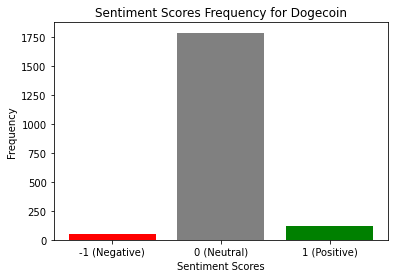

In [31]:
import matplotlib.pyplot as plt

# Assuming 'data' is your dictionary with datetime keys and sentiment score values
# data = {
#     datetime1: 1,
#     datetime2: 0,
#     datetime3: -1,
#     # Add more data here...
# }

# Extract sentiment scores from the dictionary
sentiment_scores = list(cleaned_data.values())

# Count the frequency of each sentiment score
frequency = {
    -1: sentiment_scores.count(-1),
    0: sentiment_scores.count(0),
    1: sentiment_scores.count(1)
}

# Plotting
labels = ['-1 (Negative)', '0 (Neutral)', '1 (Positive)']
x = range(len(labels))
plt.bar(x, frequency.values(), tick_label=labels, color=['red', 'gray', 'green'])
plt.xlabel('Sentiment Scores')
plt.ylabel('Frequency')
plt.title('Sentiment Scores Frequency for Dogecoin')
plt.show()


In [11]:
def get_technical_indicators(price):
    # Create 7 and 21 days Moving Average
    dataset = price.copy()

    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()

    # Create MACD
    #dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    #dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['20sd'] = dataset["Close"].rolling(window=20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    # Create Momentum
    #dataset['momentum'] = dataset['Close']-1

    # Create high-low spred
    dataset['spread'] = dataset['High'] - dataset['Low']

    return dataset

The Gold etf SPDR Gold future, has a lot of NAN values.
That might cause some issues, but let's see how it goes first.

In [12]:
 # to be finished
# def get_related_asset (price, start_date, end_date):
#     other_price = yf.download("ETH-USD", start=start_date, end=end_date)

#     price['eth']=other_price["Close"]
#     #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
#     #let's fill it with the next valid value
#     price.eth.fillna(method='bfill', inplace= True, axis=0)

#     return price

 # to be finished
def get_related_asset (price, start_date, end_date):
    other_price = yf.download("ETH-USD GLD", start=start_date, end=end_date)

    price['eth']=other_price.Close['ETH-USD']
    price['gold'] = other_price.Close['GLD']
    #there are nan values because the price datarange is not the same. so I should probalby fill the value by non-0, coz i need to do division later...
    #let's fill it with the next valid value
    price.eth.fillna(method='bfill', inplace= True, axis=0)
    price.gold.fillna(method='bfill', inplace= True, axis=0)

    return price


In [13]:
def get_label (price,threshold):


    price['change']=price.shift(-1).High/price.Close -1
    price['change_label']=price['change'].apply (lambda x: x> threshold)

    #convert True/False to 1/0
    class2idx = {True: 1, False:0}
    price['change_label'].replace(class2idx, inplace=True)
    

    return price

In [14]:
def normalise_close(price):

    df = price.copy()
    for key in df.keys():
        if not key in ['change','change_label','Volume','MACD','20sd','spread','eth','gold']:
            df[key]=df[key]/price['Close'].shift(1) - 1

    df['Volume']=df['Volume']/price['Volume'].shift(1)-1
    df['eth']  = df['eth']/price['eth'].shift(1)-1
    df['gold'] = df['gold']/price['gold'].shift(1)-1
    df['MACD'] = df['MACD']/price['Close'].shift(1)
    df['20sd'] = df['20sd']/price['Close'].shift(1)
    df['spread'] = df['spread']/price['Close'].shift(1)



    return df


In [15]:
def get_ma_feature (price,threshold):
    price['ma_feature']=price['ma7'].apply(lambda x: x > threshold)

    class2idx = {True: 1, False:0}
    price['ma_feature'].replace(class2idx, inplace=True)
    return price

In [16]:
#Here I want to define a function to return a new dataframe, that's INDEPENDANT, and produce relative price.
def process_price (original_df,threshold, start_date,end_date):
    #get the indicators
    df = get_technical_indicators(original_df)

    #get related asset
    df = get_related_asset(df,start_date,end_date)

    #get label
    df = get_label(df, threshold)

    #normalise the data
    df_normalised_close = normalise_close(df)

    #get ma label
    df_normalised_close = get_ma_feature(df_normalised_close, threshold)

    #return both normalized, and un-normalized data (w/o ma label).
    return df, df_normalised_close





In [17]:
test_df, test_df_norm = process_price(price,0.05,start_date,end_date)

[*********************100%***********************]  2 of 2 completed


In [18]:
test_df.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label
Date,,,,,,,,,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,0.005060,0
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,0.000375,0
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.021873,0
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.053544,1
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,0.047651,0


In [19]:
test_df_norm.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005060,0,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,...,NaN,NaN,NaN,0.001869,0.007236,0.0,0.000000,0.000375,0,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,...,NaN,NaN,NaN,-0.074799,0.108141,0.0,0.015077,0.021873,0,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,...,NaN,NaN,NaN,-0.028544,0.105371,0.0,0.000000,0.053544,1,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,...,NaN,NaN,NaN,0.037136,0.050179,0.0,0.000000,0.047651,0,0


In [20]:
test_df_norm.change_label.value_counts()

0    2047
1     295
Name: change_label, dtype: int64

# Some analysis with MA only

In [21]:
(test_df_norm['change_label']==test_df_norm['ma_feature']).value_counts()

True     1951
False     391
dtype: int64

In [22]:
test_df_norm['change_label'].value_counts()

0    2047
1     295
Name: change_label, dtype: int64

In [23]:
#7day ma feature

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest.

accuracy: 0.8330486763450042
[[1897  150]
 [ 241   54]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2047
           1       0.26      0.18      0.22       295

    accuracy                           0.83      2342
   macro avg       0.58      0.55      0.56      2342
weighted avg       0.81      0.83      0.82      2342



In [24]:
#for 21day ma features

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.15, but recall is higher.

accuracy: 0.8330486763450042
[[1897  150]
 [ 241   54]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2047
           1       0.26      0.18      0.22       295

    accuracy                           0.83      2342
   macro avg       0.58      0.55      0.56      2342
weighted avg       0.81      0.83      0.82      2342



In [25]:
#for ema features

#why not get a confusion matrix with these two labels and check it out.
accuracy = (test_df_norm['change_label']==test_df_norm['ma_feature']).sum() / len(test_df_norm['change_label']==test_df_norm['ma_feature'])
print ('accuracy:', accuracy)
print (confusion_matrix(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))
print (classification_report(test_df_norm['change_label'].values, test_df_norm['ma_feature'].values))

#The true label, accuracy is only 0.27, and recall rate is quite low to be honest.

accuracy: 0.8330486763450042
[[1897  150]
 [ 241   54]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      2047
           1       0.26      0.18      0.22       295

    accuracy                           0.83      2342
   macro avg       0.58      0.55      0.56      2342
weighted avg       0.81      0.83      0.82      2342



In [26]:
#so bascially 7day ma works best among these 3. got it.


# Format Custom Dataset input for Torch Models

Creating two dataset classes for future use, 1 is for classification tast, the other for Regression task

In [27]:
class ClassifierDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change_label.values
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that
        #df = df.drop (['change'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).long()





In [28]:
class RegressionDataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change.values
        df = df.drop (['change','change_label'],axis=1)
        x_values = df.values

        return torch.from_numpy(x_values).float(), torch.from_numpy(y_values).float()



In [29]:
# define a function for train_test split, and initiate dataset?
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [30]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
train_dataset = ClassifierDataset(test_df_train)
eval_dataset = ClassifierDataset (test_df_eval)

In [157]:
test_df_eval.values

array([[-0.00184557,  0.11288473, -0.02399322, ..., -0.00051759,
         0.        ,  0.        ],
       [-0.00052939, -0.00051759, -0.07245338, ...,  0.01831306,
         0.        ,  0.        ],
       [-0.00228941,  0.01831306, -0.09702536, ...,  0.03598767,
         0.        ,  0.        ],
       ...,
       [ 0.00182411,  0.01092698, -0.09516697, ...,  0.04305315,
         0.        ,  0.        ],
       [-0.00037675,  0.04305315, -0.05612914, ...,  0.05155414,
         0.        ,  0.        ],
       [-0.00025018,  0.05155414, -0.03164219, ...,         nan,
         0.        ,  0.        ]])

In [158]:
test_df_eval.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-28,-0.001846,0.112885,-0.023993,0.109501,0.109501,-0.122312,0.034310,-0.136487,-0.120168,-0.025207,...,0.140284,0.144082,-0.417055,0.086189,0.136878,0.057629,0.002710,-0.000518,0,0
2019-06-29,-0.000529,-0.000518,-0.072453,-0.036105,-0.036105,-0.147168,-0.053289,-0.206338,-0.194343,-0.108288,...,0.126154,0.045969,-0.458645,-0.031073,0.071936,0.028381,-0.019369,0.018313,0,0
2019-06-30,-0.002289,0.018313,-0.097025,-0.095508,-0.095508,-0.089142,-0.018284,-0.164151,-0.159080,-0.078060,...,0.125899,0.087647,-0.415948,-0.061932,0.115338,-0.091742,0.000000,0.035988,0,0
2019-07-01,-0.001870,0.035988,-0.067286,-0.021634,-0.021634,0.077857,0.079726,-0.064521,-0.066681,0.012994,...,0.131179,0.197838,-0.326880,-0.002049,0.103273,0.010131,0.000000,0.031092,0,0
2019-07-02,0.000524,0.031092,-0.079868,0.020650,0.020650,0.055731,0.090248,-0.030904,-0.041103,0.033126,...,0.126203,0.221502,-0.283309,0.020439,0.110960,-0.006963,0.021360,0.107983,0,0


In [159]:
# for Regression dataset construction

# test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
# train_dataset = RegressionDataset(test_df_train)
# eval_dataset = RegressionDataset (test_df_eval)

In [160]:
eval_dataset.X

tensor([[-0.0018,  0.1129, -0.0240,  ...,  0.0576,  0.0027,  0.0000],
        [-0.0005, -0.0005, -0.0725,  ...,  0.0284, -0.0194,  0.0000],
        [-0.0023,  0.0183, -0.0970,  ..., -0.0917,  0.0000,  0.0000],
        ...,
        [-0.0002,  0.0620, -0.0129,  ...,  0.0673, -0.0017,  0.0000],
        [ 0.0006,  0.0276, -0.0521,  ..., -0.0527,  0.0004,  0.0000],
        [ 0.0018,  0.0109, -0.0952,  ..., -0.1157,  0.0038,  0.0000]])

In [ ]:
train_dataset.df.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,ma_feature
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005060,0,0
2015-01-02,-0.000541,0.005060,-0.002177,0.002492,0.002492,-0.021888,NaN,NaN,0.001294,0.001350,...,NaN,NaN,NaN,0.001869,0.007236,0.0,0.000000,0.000375,0,0
2015-01-03,-0.000590,0.000375,-0.107767,-0.107767,-0.107767,3.205047,NaN,NaN,-0.039485,-0.042756,...,NaN,NaN,NaN,-0.074799,0.108141,0.0,0.015077,0.021873,0,0
2015-01-04,0.000228,0.021873,-0.083499,-0.060079,-0.060079,0.682956,NaN,NaN,0.038339,0.030899,...,NaN,NaN,NaN,-0.028544,0.105371,0.0,0.000000,0.053544,1,0
2015-01-05,0.003365,0.053544,0.003365,0.038907,0.038907,-0.209716,NaN,NaN,0.089449,0.081065,...,NaN,NaN,NaN,0.037136,0.050179,0.0,0.000000,0.047651,0,0


In [ ]:
train_dataset[1]

(tensor([ 0.0019,  0.0446, -0.0020,  0.0287,  0.0287,  0.1210, -0.0530,  0.0945,
          0.0443, -0.0017, -0.0460,  0.1607,  0.4160, -0.2269,  0.0117,  0.0467,
          0.0000,  0.0080,  0.0000]),
 tensor(0))

# Format DataLoader, different sampling options

In [ ]:
#Now let's try to flow the data into dataloader
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

The above is the normal dataloader. Below I will try to use weighted samplers, which will include oversample and undersamples, and in this case, it will also disrupt the ordering/sequence of the input, ummmmmmmmmmm, How will that affect the model performance, let's seeeeeeeee

In [ ]:
#obtain the label list.
target_list = []
for _,t in train_dataset:
  target_list.append(t)




In [ ]:
#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
class_weight

tensor([0.0009, 0.0062])

In [ ]:
#a weight for each sample
class_weights_all = class_weight[target_list]

In [ ]:
weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
for i, batch in enumerate(train_loader):
    _,t = (m for m in batch)
    print (sum(t)/len(t))

tensor(0.5312)
tensor(0.4531)
tensor(0.3750)
tensor(0.3906)
tensor(0.6562)
tensor(0.5938)
tensor(0.6562)
tensor(0.5781)
tensor(0.4062)
tensor(0.5938)
tensor(0.6094)
tensor(0.5000)
tensor(0.5156)
tensor(0.4375)
tensor(0.5312)
tensor(0.4062)
tensor(0.4844)
tensor(0.4688)
tensor(0.6250)
tensor(0.6667)


In [ ]:
#next(iter(train_loader))

In [ ]:
# for i, batch in enumerate(train_loader):
#     print (i)

In [ ]:
#weighed random sampler test.

# import torch
# from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
# train_dataset = torch.tensor([1, 1 , 1, 1, 1, 1, 1, 1, 1, 0])


# class_weights_all = [0.1, 0.1, 0.1, 0.1,0.1, 0.1, 0.1, 0.1,0.1, 0.9]

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=10,
#     replacement=True #if True, sampler will draw repeating inputs, False will have 0 repeats.
# )

# BATCH_SIZE = 5
# dataset = TensorDataset(train_dataset)
# train_loader = DataLoader(dataset,
#                           batch_size=BATCH_SIZE,
#                           sampler=weighted_sampler
# )
# for batch in train_loader:
#     print(batch)

#Format Dataset and DataLoader for LSTM

In [ ]:
class LSTMDataset(Dataset):
    def __init__(self,df,window_size):
        self.df = df
        self.window_size = window_size
        self.X, self.Y = self.clean_df()


    def __len__(self):
        return len(self.Y)


    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


    def clean_df(self):
        #drop NaN values, and also load the values into torch.tensor.
        df = self.df.dropna()
        y_values = df.change_label.values[self.window_size:]
        df = df.drop (['change','change_label'],axis=1)
        #try put the label as part of the feature see if the model cna leran that
        #df = df.drop (['change'],axis=1)
        x_values = df.values
        output = self.process(x_values)


        return torch.tensor(output,dtype=torch.float), torch.from_numpy(y_values).long()

    def process(self,data):
        output = []
        for i in range(self.window_size-1, len(data)):
            raw_data = data[i-self.window_size+1:i+1]
            output.append(raw_data)
        return output



In [ ]:
# define a function for train_test split, and initiate dataset?
def split_train_test (df, threshold):
    length = len(df)
    split_number  = round(threshold*length)
    return df[0:split_number], df[split_number:]

In [ ]:
#for classification dataset construction
test_df_train,test_df_eval = split_train_test(test_df_norm, 0.7)
WINDOW_SIZE = 10
train_dataset = LSTMDataset(test_df_train, window_size=WINDOW_SIZE)
eval_dataset = LSTMDataset (test_df_eval, window_size= WINDOW_SIZE)

<ipython-input-41-91cf3ff06750>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(output,dtype=torch.float), torch.from_numpy(y_values).long()


In [ ]:
train_dataset[0]

(tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  7.3738e-02,  7.3738e-02,
           2.4421e-01,  9.5185e-04,  1.9347e-01,  1.2295e-01,  6.5804e-02,
          -5.7147e-02,  1.8713e-01,  5.6772e-01, -1.8079e-01,  4.9743e-02,
           7.8442e-02,  0.0000e+00,  2.4160e-04,  0.0000e+00],
         [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  2.8687e-02,  2.8687e-02,
           1.2097e-01, -5.2953e-02,  9.4539e-02,  4.4277e-02, -1.6947e-03,
          -4.5971e-02,  1.6074e-01,  4.1603e-01, -2.2695e-01,  1.1676e-02,
           4.6651e-02,  0.0000e+00,  8.0496e-03,  0.0000e+00],
         [ 4.7553e-04,  6.1652e-03, -3.5175e-02, -2.2579e-03, -2.2579e-03,
          -2.6600e-01, -6.4195e-02,  4.7255e-02,  1.3600e-02, -2.5246e-02,
          -3.8846e-02,  1.5229e-01,  3.5183e-01, -2.5732e-01, -7.0176e-03,
           4.1340e-02,  0.0000e+00, -7.9853e-03,  0.0000e+00],
         [-7.6864e-04,  6.5833e-02, -1.2268e-02,  6.4274e-02,  6.4274e-02,
           6.5308e-03, -3.2272e-02,  4.2829e-02,  2.0149e-02,

In [ ]:
#a vanilla dataloader

train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )


In [ ]:
#weighted_dataloader

#obtain the label list.
target_list = []
for _,t in train_dataset:
  target_list.append(t)

#obtain the class weights
leng = len(target_list)
total_true = sum(target_list)
class_count = [leng-total_true, total_true]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)


#a weight for each sample
class_weights_all = class_weight[target_list]

weighted_sampler = WeightedRandomSampler(
    weights = class_weights_all,
    num_samples = leng,
    replacement = True
)

In [ ]:
#train_loader = DataLoader(train_dataset, batch_size = 64, sampler=weighted_sampler )
train_loader = DataLoader(train_dataset, batch_size = 64, )
eval_loader = DataLoader(eval_dataset, batch_size = 64, )
# add in shuffle/sampler options later

In [ ]:
next(iter(train_loader))

[tensor([[[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  0.0000e+00,
            2.4160e-04,  0.0000e+00],
          [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          ...,
          [-4.7061e-04,  1.1614e-02, -1.3826e-01,  ...,  0.0000e+00,
           -7.8778e-03,  0.0000e+00],
          [-2.4239e-03,  2.0482e-02, -5.6444e-02,  ...,  0.0000e+00,
           -2.1552e-02,  1.0000e+00],
          [-3.1733e-03,  3.9989e-02, -3.2863e-02,  ...,  0.0000e+00,
            2.2276e-02,  1.0000e+00]],
 
         [[ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  0.0000e+00,
            8.0496e-03,  0.0000e+00],
          [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  0.0000e+00,
           -7.9853e-03,  0.0000e+00],
          [-7.6864e-04,  6.5833e-02, -1.2268e-02,  ...,  0.0000e+00,
           -9.9815e-03,  0.0000e+00],
          ...,
    



# Torch Model 1 - FeedForward Classification

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)
        out_dist = F.log_softmax(out, dim= -1) #why is it -1, ok, coz it's batch x input x class.

        return out_dist



In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
model

FFNN(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 273,922 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.NLLLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m


In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)




In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 5

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       480
           1       0.25      0.19      0.22        67

    accuracy                           0.83       547
   macro avg       0.57      0.56      0.56       547
weighted avg       0.81      0.83      0.82       547

 Epoch Number 0
 Train. Loss: 0.678 Train. Acc: 55.99%
 Eval loss , 0.589, eval acc, 83.45 %
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       478
           1       0.29      0.22      0.25        69

    accuracy                           0.84       547
   macro avg       0.59      0.57      0.58       547
weighted avg       0.82      0.84      0.82       547

 Epoch Number 1
 Train. Loss: 0.618 Train. Acc: 67.00%
 Eval loss , 0.471, eval acc, 83.80 %
              precision    recall  f1-score   support

           0       0.83      0.92      0.88       448
           1       0.33      0.17      0.23        

In [ ]:
# #obtain the label list.
# target_list = []
# for _,t in eval_dataset:
#   target_list.append(t)

# #obtain the class weights
# leng = len(target_list)
# total_true = sum(target_list)
# class_count = [leng-total_true, total_true]
# class_count

In [ ]:
# for step,batch in enumerate(eval_loader):

#     data,label = (t for t in batch)
#     data = data.to(device)
#     label = label.to(device)

#     pred = model(data)
#     loss = loss_fn(pred,label)
#     acc = accuracy(pred,label)
#     report = get_cfm(pred,label)

#     epoch_loss += loss.item()
#     epoch_acc += acc



In [ ]:
    # pred_list =[]
    # label_list =[]
    # for step,batch in enumerate(eval_loader):
    #     data,label = (t for t in batch)
    #     data = data.to(device)
    #     label = label.to(device)

    #     pred = model(data)
    #     loss = loss_fn(pred,label)
    #     acc = accuracy(pred,label)
    #     if step ==0:
    #         pred_list=pred.cpu().detach().numpy()
    #         label_list = label.cpu().detach().numpy()
    #     if step != 0:
    #         pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
    #         label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



    # report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    # print (report)


In [ ]:
target = torch.empty(3).random_(2)
target

tensor([0., 0., 1.])

# Torch Model 1.1 - FeedForward with CE

In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)
         #why is it -1, ok, coz it's batch x input x class.

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)




In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)


        epoch_loss += loss.item()


    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)

    eval_loss = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} ')
    print (f' Eval loss , {eval_loss:.3f} ')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

 Epoch Number 0
 Train. Loss: 0.664 
 Eval loss , 0.591 
 Epoch Number 1
 Train. Loss: 0.622 
 Eval loss , 0.504 
 Epoch Number 2
 Train. Loss: 0.617 
 Eval loss , 0.569 
 Epoch Number 3
 Train. Loss: 0.579 
 Eval loss , 0.488 
 Epoch Number 4
 Train. Loss: 0.601 
 Eval loss , 0.527 
 Epoch Number 5
 Train. Loss: 0.573 
 Eval loss , 0.472 
 Epoch Number 6
 Train. Loss: 0.603 
 Eval loss , 0.544 
 Epoch Number 7
 Train. Loss: 0.581 
 Eval loss , 0.543 
 Epoch Number 8
 Train. Loss: 0.602 
 Eval loss , 0.536 
 Epoch Number 9
 Train. Loss: 0.585 
 Eval loss , 0.487 


# Torch Model 2 - Feedforward Classification with F1 loss function

In [ ]:
#let's first try a simple FC NN
class FFNN_F1 (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN_F1(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

model


FFNN_F1(
  (fc1): Linear(in_features=19, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=19, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_layer): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 273,922 trainable parameters


In [ ]:
#define optimizer, loss function
class F1_Loss(nn.Module):
    '''Calculate F1 score. Can work with gpu tensors

    The original implmentation is written by Michal Haltuf on Kaggle.

    Returns
    -------
    torch.Tensor
        `ndim` == 1. epsilon <= val <= 1

    Reference
    ---------
    - https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric
    - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
    - https://discuss.pytorch.org/t/calculating-precision-recall-and-f1-score-in-case-of-multi-label-classification/28265/6
    - http://www.ryanzhang.info/python/writing-your-own-loss-function-module-for-pytorch/
    '''
    def __init__(self, epsilon=1e-7):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true,):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, 2).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2* (precision*recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1-self.epsilon)
        return 1 - f1.mean()


params = model.parameters()
optimizer = optim.Adam(params)
loss_fn =F1_Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

print (device)

cuda


In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 10

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       474
           1       0.27      0.19      0.23        73

    accuracy                           0.82       547
   macro avg       0.58      0.56      0.56       547
weighted avg       0.80      0.82      0.81       547

 Epoch Number 0
 Train. Loss: 0.481 Train. Acc: 57.39%
 Eval loss , 0.571, eval acc, 82.76 %
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       444
           1       0.39      0.19      0.26       103

    accuracy                           0.79       547
   macro avg       0.61      0.56      0.57       547
weighted avg       0.75      0.79      0.76       547

 Epoch Number 1
 Train. Loss: 0.427 Train. Acc: 62.00%
 Eval loss , 0.521, eval acc, 79.63 %
              precision    recall  f1-score   support

           0       0.73      0.94      0.82       383
           1       0.55      0.17      0.26       1

# Torch Model 3 - Feedforward Regresssion

In [ ]:
#let's first try a simple FC NN
class FFNN_regression (nn.Module):
    def __init__(self, input_size,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,1)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out



In [ ]:
#try initiating the model
INPUT_SIZE = 18
NUM_HIDDEN = 4
HIDDEN_DIM = 1024

model = FFNN_regression(INPUT_SIZE, NUM_HIDDEN, HIDDEN_DIM)


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0

    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data).squeeze(1)
        loss = loss_fn(pred,label)


        epoch_loss += loss.item()

    return epoch_loss/len(dataloader)

In [ ]:
N_EPOCHS = 20

for i in range(N_EPOCHS):
    train_loss = train(model,train_loader, optimizer, loss_fn)
    eval_loss = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.5f} ')
    print (f' Eval loss , {eval_loss:.5f} ')


 Epoch Number 0
 Train. Loss: 0.01819 
 Eval loss , 0.01586 
 Epoch Number 1
 Train. Loss: 0.01819 
 Eval loss , 0.01614 
 Epoch Number 2
 Train. Loss: 0.01786 
 Eval loss , 0.01623 
 Epoch Number 3
 Train. Loss: 0.01790 
 Eval loss , 0.01642 
 Epoch Number 4
 Train. Loss: 0.01800 
 Eval loss , 0.01593 
 Epoch Number 5
 Train. Loss: 0.01772 
 Eval loss , 0.01546 
 Epoch Number 6
 Train. Loss: 0.01777 
 Eval loss , 0.01570 
 Epoch Number 7
 Train. Loss: 0.01737 
 Eval loss , 0.01564 
 Epoch Number 8
 Train. Loss: 0.01764 
 Eval loss , 0.01640 
 Epoch Number 9
 Train. Loss: 0.01744 
 Eval loss , 0.01590 
 Epoch Number 10
 Train. Loss: 0.01722 
 Eval loss , 0.01566 
 Epoch Number 11
 Train. Loss: 0.01740 
 Eval loss , 0.01632 
 Epoch Number 12
 Train. Loss: 0.01794 
 Eval loss , 0.01632 
 Epoch Number 13
 Train. Loss: 0.01759 
 Eval loss , 0.01537 
 Epoch Number 14
 Train. Loss: 0.01768 
 Eval loss , 0.01596 
 Epoch Number 15
 Train. Loss: 0.01705 
 Eval loss , 0.01582 
 Epoch Number 16
 

The loss seems way too small??? am I calculating it correctly???
I'm going to use L1loss instead of L2 loss and see how it goes.
It seems that the class imbalance is too dominant, I'll have to work around it.

In [ ]:
for i,batch in enumerate(train_loader):
    data,label = (t for t in batch)
    print (i)
    break

0


In [ ]:
data

tensor([[ 2.9815e-04,  7.7955e-02, -4.8741e-04,  ...,  7.8442e-02,
          0.0000e+00,  0.0000e+00],
        [ 1.8731e-03,  4.4611e-02, -2.0406e-03,  ...,  4.6651e-02,
          0.0000e+00,  0.0000e+00],
        [ 4.7553e-04,  6.1652e-03, -3.5175e-02,  ...,  4.1340e-02,
          0.0000e+00,  0.0000e+00],
        ...,
        [-2.4258e-04,  3.4845e-02, -2.3194e-02,  ...,  5.8039e-02,
          0.0000e+00,  0.0000e+00],
        [-6.1106e-04,  9.8598e-04, -8.4670e-02,  ...,  8.5656e-02,
          0.0000e+00,  0.0000e+00],
        [ 7.6427e-03,  1.4638e-02, -3.6971e-02,  ...,  5.1609e-02,
          0.0000e+00,  1.0000e+00]])

In [ ]:
label

tensor([ 0.0446,  0.0062,  0.0658,  0.0292,  0.2194,  0.0073,  0.0116,  0.0205,
         0.0400,  0.0313,  0.0649,  0.0670,  0.0324,  0.0123,  0.0553,  0.0617,
         0.0361,  0.0074,  0.0025,  0.0077,  0.0162,  0.0138,  0.0834,  0.1036,
         0.0322,  0.0200,  0.0510,  0.0026,  0.0269,  0.0284,  0.0473,  0.0076,
         0.0175,  0.0042,  0.0025,  0.0010,  0.0856,  0.0034,  0.0291,  0.0619,
         0.0367,  0.0090,  0.0314,  0.0052,  0.0188,  0.0058,  0.0669,  0.0360,
         0.0193,  0.0024,  0.0005,  0.0035,  0.0165,  0.0270,  0.0061, -0.0006,
         0.0310,  0.0150,  0.0017,  0.0374,  0.0348,  0.0010,  0.0146,  0.0331])

In [ ]:
model(data.to(device)).squeeze()

tensor([0.0306, 0.0253, 0.0240, 0.0256, 0.0248, 0.0387, 0.0230, 0.0273, 0.0294,
        0.0302, 0.0312, 0.0329, 0.0207, 0.0208, 0.0152, 0.0203, 0.0126, 0.0092,
        0.0113, 0.0096, 0.0081, 0.0083, 0.0082, 0.0177, 0.0202, 0.0215, 0.0082,
        0.0101, 0.0153, 0.0084, 0.0109, 0.0119, 0.0129, 0.0082, 0.0082, 0.0078,
        0.0074, 0.0177, 0.0110, 0.0160, 0.0200, 0.0211, 0.0205, 0.0203, 0.0196,
        0.0192, 0.0197, 0.0226, 0.0210, 0.0200, 0.0206, 0.0205, 0.0193, 0.0161,
        0.0170, 0.0176, 0.0211, 0.0222, 0.0179, 0.0064, 0.0064, 0.0088, 0.0134,
        0.0227], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
loss_fn(model(data.to(device)).squeeze(),label.to(device))

tensor(0.0214, device='cuda:0', grad_fn=<L1LossBackward>)

#Torch Model 4 - LSTM Classification

The previous 3 models used the almost the same dataloader because the similar input format, for LSTM I will need to make some adjustments. And perhaps try out 2 scenarios with and w/o the weighted sampler.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, num_classes,  num_hidden, hidden_dim):
        super().__init__()
        #num_layers = num_layers
        # self.input_size = input_size
        # self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_dim, num_hidden, batch_first=True, bidirectional=False, dropout=0.5)
        self.ff = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout()

        #need to change the loss function.
    def forward(self, input):
        output, (hn, cn) = self.lstm(input)
        hn = self.dropout(hn[-1,:,:])
        return self.ff(hn)

In [ ]:
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = LSTMModel(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
model

LSTMModel(
  (lstm): LSTM(19, 512, num_layers=2, batch_first=True, dropout=0.5)
  (ff): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
#print model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 3,193,858 trainable parameters


In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())
#loss_fn = nn.NLLLoss()
loss_fn= FocalLoss(gamma=0,alpha=0.2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    prediciton = F.softmax(preds, dim =1)
    _, pred = torch.max(prediciton, 1)
    correct = (pred == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (preds, label):
    pred = F.softmax(preds, dim =1)
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m

In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)



        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc
    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)



In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)

In [ ]:
N_EPOCHS = 15

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1219
           1       0.03      0.14      0.04        29

    accuracy                           0.85      1248
   macro avg       0.50      0.50      0.48      1248
weighted avg       0.95      0.85      0.90      1248

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       537
           1       0.00      0.00      0.00         0

    accuracy                           0.91       537
   macro avg       0.50      0.45      0.48       537
weighted avg       1.00      0.91      0.95       537

 Epoch Number 0
 Train. Loss: 0.191 Train. Acc: 85.70%
 Eval loss , 0.170, eval acc, 90.88 %
              precision    recall  f1-score   support

           0       1.00      0.87      0.93      1248
           1       0.00      0.00      0.00         0

    accuracy                           0.87      1248
   macro avg       0.50      0.44  

why is the loss negative here, did I mess up with the NLLloss? I passed the softmax into the NLLloss correctly ya?
Ah, because i used softmax, it should be log_softmax instead.

 what about the actual result here. maybe try a few more epochs?

 The results is not exactly stable ?
 It's actually a common theme, throughout all the 4 models though .

 Hard to say, the recall of true label is not very good in evaluation set, although the accuracy is going up. The recall rate in trainning set seems decent though. ummm.

 What if I want to focus on the recall rate, maybe the focal loss could come into play here ???? maybe it can address the class imbalance better than over/undersampling?

# Torch Model 5 - Feedforward with Focal Loss


Now that I understand a little bit more about Cross-entropy and the concept of focal loss, let me try it out on the most basic network and see if it works.

In [ ]:
#first, define focal loss?
#there are a few variations...let's try

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [ ]:
loss_fn = FocalLoss(gamma=0, alpha=0.2)


In [ ]:
#let's first try a simple FC NN
class FFNN (nn.Module):
    def __init__(self, input_size, num_classes,num_hidden, hidden_dim ):
        super().__init__()

        assert num_hidden > 0

        self.fc1 = nn.Linear(input_size,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,hidden_dim)

        self.hidden_layers = nn.ModuleList([])
        self.hidden_layers.append (self.fc1)
        for i in range (num_hidden -1 ):
            self.hidden_layers.append(self.fc2)

        self.final_layer = nn.Linear (hidden_dim,num_classes)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()

    def forward(self,x):
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = self.dropout(x)
            x = self.relu(x)

        out = self.final_layer(x)

        return out


In [ ]:
#try initiating the model
INPUT_SIZE = 19
NUM_CLASSES = 2
NUM_HIDDEN = 2
HIDDEN_DIM = 512

model = FFNN(INPUT_SIZE, NUM_CLASSES, NUM_HIDDEN, HIDDEN_DIM)

In [ ]:
#define loss fuction and optimizer
optimizer = optim.Adam(model.parameters())


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fn = loss_fn.to(device)

In [ ]:
#define a function to calcualte prediction accuracy
def accuracy(pred,label):
    _,pred_label = torch.max(pred,dim=1)
    correct = (pred_label==label).float()
    accuracy = correct.sum()/len(correct)
    return accuracy

#can i define a function to calculate the f1 score/confusion matrix?
def get_cfm (pred, label):
    _,pred_label = torch.max(pred,dim=1)
    m = classification_report(pred_label.cpu(), label.cpu())
    return m




In [ ]:
#now define the training and evaluation loop
def train(model, dataloader, optimizer, loss_fn):
    model.train()

    epoch_loss= 0
    epoch_acc = 0

    for step,batch in enumerate(dataloader):
        optimizer.zero_grad()

        data, label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc  = accuracy(pred,label)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc

    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
def evaluate(model,dataloader,loss_fn):
    model.eval()

    epoch_loss = 0
    epoch_acc = 0

    pred_list =[]
    label_list =[]
    for step,batch in enumerate(dataloader):
        data,label = (t for t in batch)
        data = data.to(device)
        label = label.to(device)

        pred = model(data)
        loss = loss_fn(pred,label)
        acc = accuracy(pred,label)

        #append the prediction result and show it per epoch later.
        if step ==0:
            pred_list=pred.cpu().detach().numpy()
            label_list = label.cpu().detach().numpy()
        if step != 0:
            pred_list = np.concatenate([pred_list,pred.cpu().detach().numpy()],axis =0)
            label_list = np.concatenate([label_list,label.cpu().detach().numpy()],axis =0)

        epoch_loss += loss.item()
        epoch_acc += acc

    report = get_cfm(torch.tensor(pred_list),torch.tensor(label_list))
    print (report)
    return epoch_loss/len(dataloader), epoch_acc/len(dataloader)


In [ ]:
N_EPOCHS = 20

for i in range(N_EPOCHS):
    train_loss,train_acc = train(model,train_loader, optimizer, loss_fn)

    eval_loss, eval_acc = evaluate(model,eval_loader, loss_fn)

    print (f' Epoch Number {i}')
    print (f' Train. Loss: {train_loss:.3f} Train. Acc: {train_acc*100:.2f}%')
    print (f' Eval loss , {eval_loss:.3f}, eval acc, {eval_acc*100:.2f} %')
    # print(f'\t Train. Loss: {train_loss:.3f} |  Train. Acc: {train_acc*100:.2f}%')
    # print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.91      0.95       547
           1       0.00      0.00      0.00         0

    accuracy                           0.91       547
   macro avg       0.50      0.45      0.48       547
weighted avg       1.00      0.91      0.95       547

 Epoch Number 0
 Train. Loss: 0.210 Train. Acc: 83.39%
 Eval loss , 0.156, eval acc, 90.71 %
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       498
           1       0.18      0.18      0.18        49

    accuracy                           0.85       547
   macro avg       0.55      0.55      0.55       547
weighted avg       0.85      0.85      0.85       547

 Epoch Number 1
 Train. Loss: 0.183 Train. Acc: 82.53%
 Eval loss , 0.164, eval acc, 85.19 %
              precision    recall  f1-score   support

           0       0.92      0.91      0.92       502
           1       0.14      0.16      0.15        

In [ ]:
a = torch.range(1,6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  """Entry point for launching an IPython kernel.


In [ ]:
a

tensor([1., 2., 3., 4., 5., 6.])

# Torch Model 6 -  SVM and PCA

In [21]:
test_df.reset_index(inplace=True)

In [22]:
test_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,...,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,0.005060,0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,...,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,0.000375,0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,...,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.021873,0


In [23]:
# Convert the 'date' column to datetime
test_df['Date'] = pd.to_datetime(test_df['Date'])


In [24]:
print(cleaned_data)

{datetime.date(2015, 1, 1): -1, datetime.date(2015, 1, 2): 1, datetime.date(2015, 1, 3): 0, datetime.date(2015, 1, 4): 0, datetime.date(2015, 1, 5): -1, datetime.date(2015, 1, 6): -1, datetime.date(2015, 1, 7): -1, datetime.date(2015, 1, 8): -1, datetime.date(2015, 1, 9): 0, datetime.date(2015, 1, 10): 1, datetime.date(2015, 1, 11): -1, datetime.date(2015, 1, 12): 1, datetime.date(2015, 1, 13): 0, datetime.date(2015, 1, 14): 0, datetime.date(2015, 1, 15): 0, datetime.date(2015, 1, 16): -1, datetime.date(2015, 1, 17): 0, datetime.date(2015, 1, 18): 0, datetime.date(2015, 1, 19): 1, datetime.date(2015, 1, 20): -1, datetime.date(2015, 1, 21): 1, datetime.date(2015, 1, 22): 1, datetime.date(2015, 1, 23): 0, datetime.date(2015, 1, 24): -1, datetime.date(2015, 1, 25): 0, datetime.date(2015, 1, 26): -1, datetime.date(2015, 1, 27): -1, datetime.date(2015, 1, 28): 0, datetime.date(2015, 1, 29): 1, datetime.date(2015, 1, 30): 1, datetime.date(2015, 1, 31): 1, datetime.date(2015, 2, 1): -1, datet

In [25]:
test_df["sentimet_score"]=test_df["Date"].map(cleaned_data)

In [26]:
print ("Shape of DataFrame: ", test_df.shape)

Shape of DataFrame:  (2342, 22)


In [27]:
type(test_df["sentimet_score"][0])

numpy.float64

In [28]:
test_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,20sd,upper_band,lower_band,ema,spread,eth,gold,change,change_label,sentimet_score
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,...,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,0.005060,0,-1.0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,...,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,0.000375,0,1.0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,...,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.021873,0,0.0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,...,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.053544,1,0.0
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,...,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,0.047651,0,-1.0


<ipython-input-29-15f57507c83c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = test_df.corr()


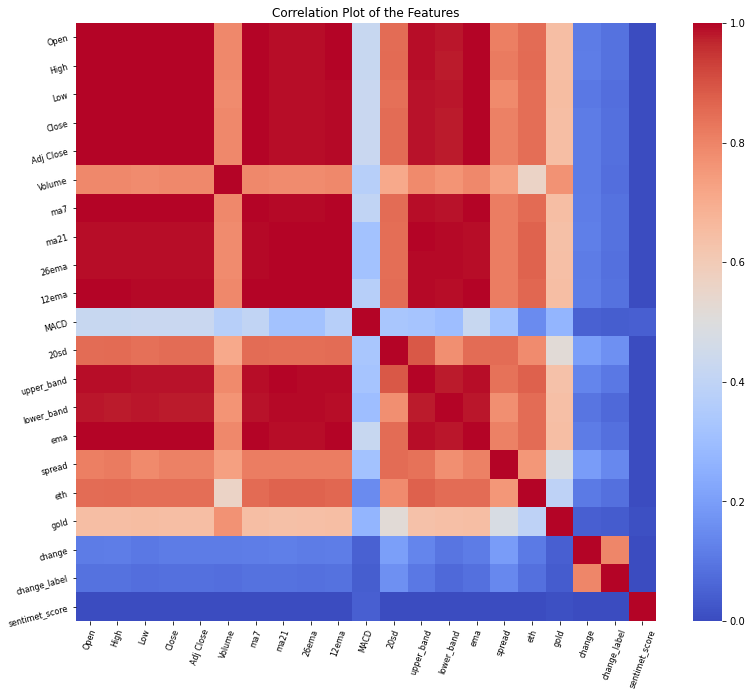

In [29]:
corr = test_df.corr()
#fig = plt.figure()
#plt.subplot(1, 2, 1)
fig=plt.figure(figsize=(13,11))
g1 = sns.heatmap(corr, cmap='coolwarm', vmin=0, vmax=1)
g1.set_xticklabels(g1.get_xticklabels(), rotation=70, fontsize=8)
g1.set_yticklabels(g1.get_yticklabels(), rotation=15, fontsize=8)
plt.title("Correlation Plot of the Features")
plt.savefig("Corr_Features.png", dpi=200)
plt.show()

C:\Users\kunal\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


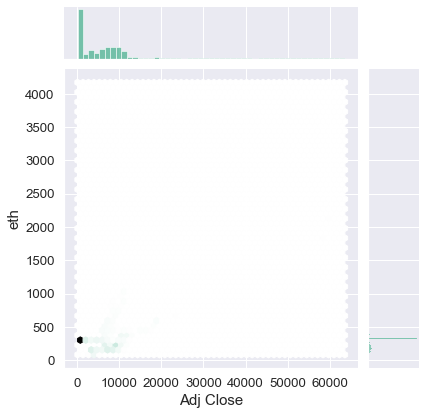

In [30]:
sns.set(font_scale=1.2)
j=sns.jointplot(test_df['Adj Close'], test_df['eth']
, kind='hex', color="#4CB391")
j.set_axis_labels('Adj Close', 'eth', fontsize=15)


C:\Users\kunal\AppData\Roaming\Python\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


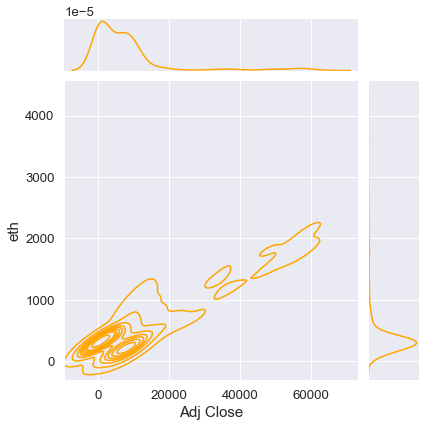

In [31]:
j2 = sns.jointplot(test_df['Adj Close'], test_df['eth'], kind='kde', color='orange')
j2.set_axis_labels('Adj Close', 'eth', fontsize=15)


In [32]:
X= test_df.drop(columns = ['change','change_label'])
Y = test_df.change_label

In [33]:
X.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0


In [34]:
X.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
2337,2021-05-26,38392.625000,40782.078125,37905.835938,39294.199219,39294.199219,51346735160,38113.863839,46455.394903,45730.196464,41038.820893,-4691.375571,8101.034222,62657.463347,30253.326460,38922.095348,2876.242188,2888.698730,177.639999,1.0
2338,2021-05-27,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,43210968721,37778.753906,45600.178385,45189.957374,40638.535948,-4551.421426,7799.008921,61198.196227,30002.160544,38598.677616,3131.714844,2736.488525,177.710007,-1.0
2339,2021-05-28,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,55200191952,37549.170201,44568.807106,44486.820196,39878.392797,-4608.427399,7346.797712,59262.402529,29875.211683,36664.629518,4077.929688,2419.906250,178.380005,1.0
2340,2021-05-29,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,45231013335,37131.946429,43417.011347,43755.653248,39068.804122,-4686.849127,6791.615698,57000.242742,29833.779952,35298.920777,3540.570312,2279.514160,NaN,1.0
2341,2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921,37261.595982,42343.002418,43157.318112,38547.161781,-4610.156331,6203.553645,54750.109709,29935.895128,35551.726196,2879.929688,2390.305420,NaN,-1.0


In [35]:
print(len(X))

2342


In [36]:
# X.reset_index(inplace = True)

In [37]:
X.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0


In [38]:
startidx = X[X["Date"] == "2020-06-30"].index[0]
print(startidx)

2007


In [39]:
print(len(X),len(Y))

2342 2342


In [40]:
X_train = X[:2007]
X_test = X[2007:]
Y_train = Y[:2007]
Y_test = Y[2007:]

In [41]:
#test_df2=test_df.drop(['change','change_label'])
# X_train, X_test, Y_train, Y_test = train_test_split(test_df.drop(['change','change_label'],axis =1 ), test_df.change_label, test_size=0.25,
#                                                     stratify=test_df.change_label, random_state=30)

print ("train feature shape: ", X_train.shape)
print ("test feature shape: ", X_test.shape)

train feature shape:  (2007, 20)
test feature shape:  (335, 20)


In [42]:
X_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,314.248993,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,314.655561,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,302.592907,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,291.858532,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,287.826987,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0


#now PCA.

In [43]:
X_train.isnull().sum()

Date                0
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
ma7                 6
ma21               20
26ema               0
12ema               0
MACD                0
20sd               19
upper_band         20
lower_band         20
ema                 0
spread              0
eth                 0
gold                0
sentimet_score    102
dtype: int64

In [44]:
X_train_drop = X_train.dropna()

In [45]:
X_train.reset_index(inplace = True)

In [46]:
X_train.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,...,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,...,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,...,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,...,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,...,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,...,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0


In [47]:
naInd = []

In [48]:
for i in range(len(X_train)):
  if(X_train.iloc[i][:].isna().any()):
    naInd.append(i)

In [49]:
naInd

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 364,
 470,
 584,
 730,
 1095,
 1287,
 1296,
 1366,
 1460,
 1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1467,
 1468,
 1469,
 1470,
 1471,
 1472,
 1473,
 1474,
 1475,
 1476,
 1477,
 1478,
 1479,
 1480,
 1481,
 1482,
 1483,
 1484,
 1485,
 1486,
 1487,
 1488,
 1489,
 1490,
 1491,
 1492,
 1493,
 1494,
 1495,
 1496,
 1497,
 1498,
 1499,
 1500,
 1501,
 1502,
 1503,
 1504,
 1505,
 1506,
 1507,
 1508,
 1509,
 1510,
 1511,
 1512,
 1513,
 1514,
 1515,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1522,
 1523,
 1524,
 1525,
 1526,
 1527,
 1528,
 1529,
 1530,
 1531,
 1532,
 1533,
 1534,
 1535,
 1536,
 1537,
 1538,
 1539,
 1540,
 1541,
 1542,
 1543,
 1544,
 1545,
 1546,
 1547,
 1548,
 1549,
 1550,
 1627,
 1749,
 1755]

In [50]:
s=(X_train.columns)

In [51]:
X_train_drop = pd.DataFrame(columns=s)
Y_train_drop = []


In [52]:
X_train.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,...,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,...,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,...,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,...,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,...,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,...,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0


In [53]:
X_train

,index,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,...,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,...,314.248993,0.000000,NaN,NaN,NaN,314.248993,6.432007,320.884003,114.080002,-1.0
1,1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,...,314.673129,0.017568,NaN,NaN,NaN,314.836258,2.273987,320.884003,114.080002,1.0
2,2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,...,301.562504,-1.030403,NaN,NaN,NaN,291.467926,34.067993,320.884003,115.800003,0.0
3,3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,...,289.767045,-2.091487,NaN,NaN,NaN,273.058706,29.618011,320.884003,115.800003,0.0
4,4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,...,285.611979,-2.215008,NaN,NaN,NaN,274.006134,13.256989,320.884003,115.800003,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,2002,2020-06-25,9314.126953,9340.161133,9095.324219,9264.813477,9264.813477,18616048626,9397.255580,9516.269113,...,9433.064577,-1.581232,189.926633,9896.122379,9136.415847,9312.766762,244.836914,232.944489,165.800003,1.0
2003,2003,2020-06-26,9260.995117,9310.516602,9101.738281,9162.917969,9162.917969,18341465837,9379.384068,9492.335054,...,9391.503560,-23.014260,201.569904,9895.474861,9089.195247,9212.867566,208.778320,229.668045,166.539993,1.0
2004,2004,2020-06-27,9167.824219,9207.810547,8998.216797,9045.390625,9045.390625,17273093144,9338.391183,9463.368908,...,9338.255416,-48.919649,213.213894,9889.796696,9036.941120,9101.216272,209.593750,222.959793,166.630005,1.0
2005,2005,2020-06-28,9048.460938,9197.546875,8975.525391,9143.582031,9143.582031,14560870760,9315.527204,9434.070312,...,9308.305665,-60.825472,209.360130,9852.790573,9015.350052,9129.460112,222.021484,225.347168,166.630005,0.0


In [54]:
Y_train_index = Y_train.index.to_list()

In [55]:
print(len(Y_train),len(Y_train_index))

2007 2007


In [56]:
Y_train_index_drop = []
Y_train_drop = []

In [57]:
for i in range(len(X_train)):
  if i in naInd:
    continue
  else:
    X_train_drop = X_train_drop.append(X_train.loc[i], ignore_index=True)
    Y_train_drop.append(Y_train[i])
    Y_train_index_drop.append(Y_train_index[i])


<ipython-input-57-9f86d37af0e2>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train_drop = X_train_drop.append(X_train.loc[i], ignore_index=True)


In [58]:
X_train_drop.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,...,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,20,2015-01-21,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,211.516142,252.197332,...,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443,16.575989,320.884003,124.230003,1.0
1,21,2015-01-22,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,214.882143,248.347666,...,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152,10.584991,320.884003,125.230003,1.0
2,22,2015-01-23,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,218.422429,244.435617,...,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049,9.649002,320.884003,124.230003,0.0
3,23,2015-01-24,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,225.363429,242.852998,...,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350,18.188004,320.884003,122.989998,-1.0
4,24,2015-01-25,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,231.560429,242.354093,...,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451,11.184006,320.884003,122.989998,0.0


In [59]:
X_train_drop.isna().sum()

index             0
Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
ma7               0
ma21              0
26ema             0
12ema             0
MACD              0
20sd              0
upper_band        0
lower_band        0
ema               0
spread            0
eth               0
gold              0
sentimet_score    0
dtype: int64

In [60]:
X_train_drop_noDate = X_train_drop.drop(columns=["Date"])

In [61]:
# clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability = True))
# clf.fit(X_train_drop_noDate,Y_train_drop)

In [62]:
# Y_test.reset_index(inplace = True)

In [63]:
X_test_dropDate = X_test

In [64]:
X_test_dropDate.drop("Date",inplace = True,axis =1 )

<ipython-input-64-4f5fc701274b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_dropDate.drop("Date",inplace = True,axis =1 )


In [65]:
Y_test=Y_test.reset_index()

In [66]:
Y_test.drop(columns=["index"],inplace=True)

In [67]:
X_test_dropDate.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
2007,9185.581055,9217.835938,9084.837891,9137.993164,9137.993164,15735797744,9179.880301,9375.101656,9339.782327,9266.814240,-72.968087,166.107327,9707.316309,9042.887002,9148.792009,132.998047,226.315002,167.369995,1.0
2008,9145.985352,9309.754883,9104.735352,9228.325195,9228.325195,15971550355,9167.696708,9344.541202,9331.526243,9260.892848,-70.633394,168.254004,9681.049210,9008.033193,9201.814133,205.019531,231.113419,166.619995,1.0
2009,9231.139648,9274.962891,9036.623047,9123.410156,9123.410156,16338916796,9147.496233,9335.094959,9316.110236,9239.741665,-76.368571,172.080905,9679.256770,8990.933148,9149.544815,238.339844,229.392197,166.979996,1.0
2010,9124.842773,9202.344727,9058.794922,9087.303711,9087.303711,13078970999,9136.694196,9316.354957,9299.161605,9216.289672,-82.871933,176.395709,9669.146376,8963.563539,9108.050746,143.549805,225.387070,167.979996,-1.0
2011,9084.233398,9183.295898,9053.629883,9132.488281,9132.488281,12290528515,9149.136719,9300.031669,9286.815433,9203.397150,-83.418282,179.585018,9659.201704,8940.861633,9124.342436,129.666016,229.074112,167.979996,-1.0


In [68]:
X_test_dropDate.reset_index(inplace=True)

In [69]:
X_test_dropDate.drop(columns=["index"],inplace=True)

<ipython-input-69-ca71dd698094>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_dropDate.drop(columns=["index"],inplace=True)


In [70]:
Y_test=Y_test["change_label"]

In [71]:
type(Y_test)

pandas.core.series.Series

In [72]:
X_test_drop = pd.DataFrame(columns=s)
Y_test_drop = []
naIndTest = []

In [73]:
for i in range(len(X_test_dropDate)):
  if(X_test.iloc[i][:].isna().any()):
    naIndTest.append(i)

In [74]:
for i in range(len(X_test_dropDate)):
  if i in naIndTest:
    continue
  else:
    X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
    Y_test_drop.append(Y_test[i])


<ipython-input-74-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-74-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-74-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-74-b348a81f7154>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test_drop = X_test_drop.append(X_test_dropDate.loc[i], ignore_index=True)
<ipython-input-7

In [75]:
X_test_drop.drop(columns = ["Date"], inplace = True) # This is the ifnal

In [76]:
X_test_drop.isna().sum()

index             331
Open                0
High                0
Low                 0
Close               0
Adj Close           0
Volume              0
ma7                 0
ma21                0
26ema               0
12ema               0
MACD                0
20sd                0
upper_band          0
lower_band          0
ema                 0
spread              0
eth                 0
gold                0
sentimet_score      0
dtype: int64

In [77]:
# Y_pred_probs = clf.predict_proba(X_test_drop)

In [78]:

# print(Y_test_drop)

In [79]:
# print(Y_pred_probs)

In [80]:
def getLabel(arr):
  if(arr[0]>arr[1]):
    return 0
  return 1


In [81]:
Y_pred = []

In [82]:
# for i in range(len(Y_pred_probs)):
#   Y_pred.append(getLabel(Y_pred_probs[i]))

In [83]:
# print(Y_pred)

In [84]:
from sklearn.model_selection import GridSearchCV


In [85]:
X_train_drop_noDate.drop(columns=["index"],inplace=True)

In [86]:
X_train_drop_noDate.head()

,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,spread,eth,gold,sentimet_score
0,211.378006,227.787994,211.212006,226.897003,226.897003,29924600,211.516142,252.197332,237.296354,225.220423,-12.075931,39.542978,331.283287,173.111376,221.826443,16.575989,320.884003,124.230003,1.0
1,227.322006,237.018997,226.434006,233.406006,233.406006,33544600,214.882143,248.347666,236.943225,226.512490,-10.430735,36.472461,321.292588,175.402743,229.546152,10.584991,320.884003,125.230003,1.0
2,233.516998,234.845001,225.195999,232.878998,232.878998,24621700,218.422429,244.435617,236.580372,227.513418,-9.066953,35.544410,315.524437,173.346798,231.768049,9.649002,320.884003,124.230003,0.0
3,232.699997,248.210007,230.022003,247.847000,247.847000,24782500,225.363429,242.852998,237.571188,230.699476,-6.871711,35.208124,313.269246,172.436750,242.487350,18.188004,320.884003,122.989998,-1.0
4,247.352005,255.074005,243.889999,253.718002,253.718002,33582700,231.560429,242.354093,238.971756,234.296011,-4.675745,34.492524,311.339142,173.369045,249.974451,11.184006,320.884003,122.989998,0.0


In [92]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Assume 'df' is your DataFrame of features and 'l' is your list of labels
X = df  # features
y = l    # labels

# Define the undersampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling
X_res, y_res = rus.fit_resample(X, Y_train_drop)

# Convert the resampled features back into a DataFrame
df_resampled = pd.DataFrame(X_res, columns=df.columns)
df_resampled['label'] = y_res


ModuleNotFoundError: No module named 'imblearn'

In [93]:
# import pandas as pd
# import numpy as np

# Sample data (replace with your actual data)
# X_train_drop_noDate = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': [6, 7, 8, 9, 10]})
# Y_train_drop = [0, 1, 0, 1, 0]  # Sample labels (0 or 1)

# Count class occurrences
class_counts = np.unique(Y_train_drop, return_counts=True)

# Get the minority and majority class labels and counts
if class_counts[1][0] > class_counts[1][1]:
    majority_class = 0
    minority_class = 1
else:
    majority_class = 1
    minority_class = 0

# Get indices for each class
majority_class_indices = np.where(np.array(Y_train_drop) == majority_class)[0]
minority_class_indices = np.where(np.array(Y_train_drop) == minority_class)[0]

# Undersample the majority class to match the minority class size
undersampled_majority_indices = np.random.choice(majority_class_indices, size=len(minority_class_indices), replace=False)

# Combine the undersampled majority indices with all the minority class indices
final_indices = np.concatenate((undersampled_majority_indices, minority_class_indices))

# Get the final undersampled data and labels
X_train_undersampled = X_train_drop_noDate.iloc[final_indices]
Y_train_undersampled = [Y_train_drop[i] for i in final_indices]

# Optionally shuffle the data to mix the classes (recommended)
shuffle_indices = np.random.permutation(len(Y_train_undersampled))
X_train_undersampled = X_train_undersampled.iloc[shuffle_indices].reset_index(drop=True)
Y_train_undersampled = [Y_train_undersampled[i] for i in shuffle_indices]

# Print the results
print("Undersampled Data:")
print(X_train_undersampled)
print("Undersampled Labels:")
print(Y_train_undersampled)


Undersampled Data:
             Open          High           Low         Close     Adj Close  \
0     6739.209961   6767.740234   6320.720215   6329.950195   6329.950195   
1     1037.239990   1063.030029   1036.680054   1054.229980   1054.229980   
2     1596.920044   1723.349976   1596.920044   1723.349976   1723.349976   
3     8705.708008   8730.873047   8484.843750   8491.992188   8491.992188   
4    10552.599609  11273.799805  10513.200195  11225.299805  11225.299805   
..            ...           ...           ...           ...           ...   
461    371.437012    382.363007    370.382996    377.321014    377.321014   
462    325.941986    365.359985    323.209015    361.188995    361.188995   
463   7420.272949   7454.824219   7276.308105   7292.995117   7292.995117   
464  11354.299805  11905.487305  11179.144531  11815.986328  11815.986328   
465   6357.009766   6741.750000   6357.009766   6741.750000   6741.750000   

          Volume           ma7          ma21         26e

In [94]:
Y_train_undersampled

[0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,


In [109]:
class_counts = np.unique(Y_train_undersampled, return_counts=True)

In [110]:
print(class_counts)

(array([0, 1], dtype=int64), array([233, 233], dtype=int64))


In [130]:
param_grid = {'C': [0.1, 0.5,10, 100, 1000],
              'gamma': [ 1,0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(probability = True), param_grid, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_train_undersampled, Y_train_undersampled)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.495 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.500 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 0.5, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [133]:
print(grid.best_params_)


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [132]:
X_test_drop.drop(columns=["index"],inplace=True)

KeyError: "['index'] not found in axis"

In [134]:
Y_pred_probs = grid.predict_proba(X_test_drop)


In [135]:
print(len(Y_pred_probs))

331


In [136]:
Y_pred = []

In [137]:
for i in range(len(Y_pred_probs)):
  Y_pred.append(getLabel(Y_pred_probs[i]))

In [138]:
c=0
for x in Y_pred:
    if x == 1:
        c+=1
print(c)

0


In [121]:
len(Y_test_drop)

331

In [104]:
Y_test_drop.append(1)
Y_test_drop.append(0)

In [107]:
Y_test_drop.pop()

1

In [108]:
print(classification_report(Y_test_drop, Y_pred))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91       278
           1       0.00      0.00      0.00        53

    accuracy                           0.84       331
   macro avg       0.42      0.50      0.46       331
weighted avg       0.71      0.84      0.77       331



c:\Users\kunal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kunal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kunal\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
# pipe = Pipeline([
#     # ('scaler', StandardScaler()),  # StandardScaler as the first step
#     ('svm', SVC(probability = True))  # SVM as the second step
# ])
# grid_search = GridSearchCV(pipe, param_grid, cv=4)
# grid.fit(X_train_drop_noDate, Y_train_drop)

In [ ]:
# print(grid.best_params_)


{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [13]:
df_eth = pd.read_csv('Ethereum_tweets.csv')

In [14]:
df_eth.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,#1 Crypto Currency TRADING,NaN,"Profit thought trading, Learn , Trade & Earn💲....",2021-11-10 10:42:01+00:00,4,0,0,False,2021-11-15 07:26:39+00:00,Get upto 1000 that’s 10x with our premium spot...,NaN,Twitter for Android,False
1,Reyrey,Kuala Lumpur,Artist | NFT Broker & Collector for AnideaNFT ...,2011-03-07 07:22:57+00:00,343,650,589,False,2021-11-15 07:26:35+00:00,"Adopted a Hypocat #053, “Crazy Rich Cat” 🤑💵💵💵🤩...","['SupportingCreators', 'CryptoArt', 'CryptoArt...",Twitter for iPhone,False
2,akter jahan,NaN,NaN,2021-10-28 13:28:05+00:00,1,2,0,False,2021-11-15 07:26:32+00:00,Top 10 Coins by Social Engagement over the las...,"['LunarCrush', 'bitcoin', 'dogecoin']",Twitter Web App,False
3,riyan,NaN,i always paricipated your project,2021-09-16 16:59:11+00:00,11,127,99,False,2021-11-15 07:26:30+00:00,Requesting faucet funds into 0x5278942b39deD8c...,"['Rinkeby', 'Ethereum']",Twitter Web App,False
4,Michelle Eriksen,NaN,"Art Creator, NFT, Crypto",2021-08-11 06:40:08+00:00,522,1428,16,False,2021-11-15 07:26:30+00:00,New Listing BTS 0.008ETH !! \n#NFTs #nftcolle...,"['NFTs', 'nftcollector', 'NFTCommunity', 'art'...",Twitter Web App,False


In [15]:
df_eth.shape

(10000, 13)

In [16]:
df_eth.sort_values(by = "user_created", inplace = True)

In [17]:
df_eth.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
8906,septimius.eth,New York,"Investor, designer, tinkerer.\nFirst Principle...",2006-09-28 10:25:52+00:00,1808,419,2531,False,2021-11-14 15:23:55+00:00,$ETH for art 🖼 nfts\n$SOL for game 👾 nfts\n\nO...,"['NFTs', 'SOL', 'Solana', 'ETH', 'Ethereum']",Twitter for iPhone,False
8867,septimius.eth,New York,"Investor, designer, tinkerer.\nFirst Principle...",2006-09-28 10:25:52+00:00,1808,419,2531,False,2021-11-14 15:28:47+00:00,I just signed in with Ethereum!\n\n#Ethereum #...,"['Ethereum', 'ENS', 'eth']",Twitter for iPhone,False
2143,Eric M77,Guangzhou,artist - teacher - expat thriving in China #nf...,2006-11-08 05:47:40+00:00,1153,1494,13532,False,2021-11-15 02:41:30+00:00,Flow\n\nhttps://t.co/4Mtl6fpxxV\n#nftcollector...,"['nftcollectors', 'NFTs', 'NFTGiveaway', 'mech...",Twitter for iPad,False
8273,mahdi.crypto,"London, United Kingdom","👋 Mahdi Taghizadeh • Obsessed w/ high tech, co...",2007-01-28 10:39:33+00:00,11608,1328,26870,True,2021-11-14 16:21:39+00:00,It’s amazing that how the software scalability...,NaN,Twitter for Mac,False
7118,LordAlex Leon,"Montréal, Québec","LordAlex Leon. (LA) Problem Solver, Starter an...",2007-02-15 02:07:14+00:00,1534,258,52,False,2021-11-14 17:51:41+00:00,Requesting faucet funds into 0x2B2F0F2A009b7c4...,['Ethereum'],Twitter for Mac,False


In [18]:
df2 = pd.read_csv("dataset_52-person-from-2021-02-05_2023-06-12_21-34-17-266_with_importance_coefficient_and_clean_text.csv")

In [19]:
df2.head()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
0,32666,2021-02-01,154,#privacy is a human right. learn how to make y...,Privacy,bitcoin,NaN,1356346632443453446,False,https://pbs.twimg.com/media/EtK2Eq2W8AUNcgj.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,340.0,0.000588,privacy human right learn make bitcoin transac...,18,23
1,29639,2021-02-01,17,"overall btc trading volume has increased, but ...",NaN,NaN,NaN,1356358771711291396,False,https://pbs.twimg.com/media/EtLBHWbXcAEP_uD.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,39.5,0.000068,overall btc trading volume increased average t...,1,5
2,29613,2021-02-01,3,"on average, the return distribution of btc ske...",NaN,NaN,NaN,1356371560215539716,False,https://pbs.twimg.com/media/EtLMvt3XUAARAym.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,7.0,0.000012,average return distribution btc skews slightly...,0,1
3,29602,2021-02-01,3,"in their latest report on our research hub, @g...",NaN,NaN,NaN,1356387489645273096,False,NaN,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,7.0,0.000012,latest report research hub gda_capital talk se...,0,1
4,39638,2021-02-01,3496,i sent some! https://t.co/mfyrz35zjf\n\nyou sh...,NaN,NaN,NaN,1356177116744839169,False,NaN,...,vitalik.eth,4927742,VitalikButerin,19406,https://t.co/IHF9ic0Ejh,8043.5,0.013905,sent httpstcomfyrz35zjf givedirectly great wor...,731,686


In [20]:
len(df2)

40066

In [21]:
df2.tail()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
40061,1300,2023-06-12,0,rt @crypto_crib_: the altcoin market capâ is d...,NaN,NaN,NaN,1668271123929104389,True,https://pbs.twimg.com/media/FybjdVVWAAIhP3a.jpg,...,Gordon,397412,AltcoinGordon,70593,NaN,9.0,0.000016,rt crypto_crib_ altcoin market capâ 145b since...,0,9
40062,1299,2023-06-12,0,rt @knveth: fumbling generational wealth was j...,NaN,NaN,NaN,1668272169128804354,True,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,45.0,0.000078,rt knveth fumbling generational wealth part lo...,0,45
40063,1298,2023-06-12,0,rt @crypto_crib_: pakistan has ditched the us ...,NaN,NaN,NaN,1668298530232971265,True,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,12.0,0.000021,rt crypto_crib_ pakistan ditched u dollar paid...,0,12
40064,1312,2023-06-12,0,"rt @crypto_crib_: jpmorgan calls for ""comprehe...",NaN,NaN,NaN,1668236227483500548,True,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,8.0,0.000014,rt crypto_crib_ jpmorgan call comprehensive fr...,0,8
40065,0,2023-06-12,63,"trending: ""usðºð¸ congressman files legisl...",NaN,NaN,NaN,1668346189413056513,False,https://pbs.twimg.com/media/Fycn_orWYBUHK3n.jpg,...,LunarCrush,293955,LunarCrush,31251,https://t.co/6gqYX40pu4,175.0,0.000303,trending usðºð congressman file legislation fi...,48,25


In [22]:
filtered_df = df2[df2['full_text'].str.contains('eth', case=False)]


In [23]:
filtered_df.head()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
9,32685,2021-02-01,65,attended any of the 30+ livestream events iâ...,bitcoin,ethereum,lightningnetwork,1356165445431255040,False,https://pbs.twimg.com/media/EtIRSODW8AAYmKN.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,147.0,0.000254,attended 30 livestream event iâve held last ye...,8,13
19,31579,2021-02-02,88,this week will be the first sunday livestream ...,bitcoin,ethereum,lightning,1356709034066391047,False,https://pbs.twimg.com/media/EtP_rN4XMAgI8WT.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,194.5,0.000336,week first sunday livestream host month join l...,5,16
23,29247,2021-02-03,10,"in his latest investment note, @jdorman81 of @...",NaN,NaN,NaN,1357013087392563200,False,https://pbs.twimg.com/media/EtUUNjOXMAIgZFi.png,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,26.0,0.000045,latest investment note jdorman81 arca share ey...,0,6
24,29206,2021-02-03,4,eth futures funding rates from the 4 largest e...,NaN,NaN,NaN,1357081274649894914,False,https://pbs.twimg.com/media/EtVSOj_WQAQq_S1.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,10.0,0.000017,eth future funding rate 4 largest exchange sho...,0,2
29,29237,2021-02-03,7,quick quiz: what is ethâs strongest trading ...,NaN,NaN,NaN,1357025021684813826,False,https://pbs.twimg.com/media/EtUfEMGWQAMO4DL.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,18.0,0.000031,quick quiz ethâs strongest trading pair kaikod...,0,4


In [24]:
len(filtered_df)

4285

In [25]:
substrings = ['btc', 'bitcoin']

# Creating a regex pattern to search for any of the substrings
pattern = '|'.join(substrings)  # This will create 'eth|ore|lex'

# Filtering rows where the column contains any of the substrings
filtered_df_btc = df2[df2['full_text'].str.contains(pattern, case=False)]

In [26]:
filtered_df_btc.head()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
0,32666,2021-02-01,154,#privacy is a human right. learn how to make y...,Privacy,bitcoin,NaN,1356346632443453446,False,https://pbs.twimg.com/media/EtK2Eq2W8AUNcgj.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,340.0,0.000588,privacy human right learn make bitcoin transac...,18,23
1,29639,2021-02-01,17,"overall btc trading volume has increased, but ...",NaN,NaN,NaN,1356358771711291396,False,https://pbs.twimg.com/media/EtLBHWbXcAEP_uD.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,39.5,0.000068,overall btc trading volume increased average t...,1,5
2,29613,2021-02-01,3,"on average, the return distribution of btc ske...",NaN,NaN,NaN,1356371560215539716,False,https://pbs.twimg.com/media/EtLMvt3XUAARAym.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,7.0,0.000012,average return distribution btc skews slightly...,0,1
5,32660,2021-02-01,0,rt @reg_mati: la privacidad es un derecho huma...,Bitcoin,NaN,NaN,1356368418715299840,True,NaN,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,7.0,0.000012,rt reg_mati la privacidad e un derecho humano ...,0,7
6,29686,2021-02-01,7,the grayscale premium represents the differenc...,NaN,NaN,NaN,1356275347906461698,False,https://pbs.twimg.com/media/EtJ1PA0UUAAM2Ql.png,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,16.0,0.000028,grayscale premium represents difference market...,0,2


In [27]:
len(filtered_df_btc)

7268

In [28]:
substrings = ['eth', 'ethereum']

# Creating a regex pattern to search for any of the substrings
pattern = '|'.join(substrings)  # This will create 'eth|ore|lex'

# Filtering rows where the column contains any of the substrings
filtered_df_eth = df2[df2['full_text'].str.contains(pattern, case=False)]

In [29]:
len(filtered_df_eth)

4285

In [30]:
filtered_df_eth.head()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
9,32685,2021-02-01,65,attended any of the 30+ livestream events iâ...,bitcoin,ethereum,lightningnetwork,1356165445431255040,False,https://pbs.twimg.com/media/EtIRSODW8AAYmKN.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,147.0,0.000254,attended 30 livestream event iâve held last ye...,8,13
19,31579,2021-02-02,88,this week will be the first sunday livestream ...,bitcoin,ethereum,lightning,1356709034066391047,False,https://pbs.twimg.com/media/EtP_rN4XMAgI8WT.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,194.5,0.000336,week first sunday livestream host month join l...,5,16
23,29247,2021-02-03,10,"in his latest investment note, @jdorman81 of @...",NaN,NaN,NaN,1357013087392563200,False,https://pbs.twimg.com/media/EtUUNjOXMAIgZFi.png,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,26.0,0.000045,latest investment note jdorman81 arca share ey...,0,6
24,29206,2021-02-03,4,eth futures funding rates from the 4 largest e...,NaN,NaN,NaN,1357081274649894914,False,https://pbs.twimg.com/media/EtVSOj_WQAQq_S1.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,10.0,0.000017,eth future funding rate 4 largest exchange sho...,0,2
29,29237,2021-02-03,7,quick quiz: what is ethâs strongest trading ...,NaN,NaN,NaN,1357025021684813826,False,https://pbs.twimg.com/media/EtUfEMGWQAMO4DL.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,18.0,0.000031,quick quiz ethâs strongest trading pair kaikod...,0,4


In [31]:
elon_tweets = pd.read_csv("TweetsElonMusk.csv",index_col=0)

In [32]:
elon_tweets.head()

,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,
1381273474400800773,1381002894032347138,2021-04-11 18:50:33 EEST,2021-04-11,18:50:33,300,44196397,elonmusk,Elon Musk,NaN,@vincent13031925 For now. Costs are decreasing...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vincent13031925', 'name': 'V...",NaN,NaN,NaN,NaN
1381273076709478403,1372444955050971142,2021-04-11 18:48:58 EEST,2021-04-11,18:48:58,300,44196397,elonmusk,Elon Musk,NaN,Love this beautiful shot,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1381258144916008964,1381230136918433792,2021-04-11 17:49:38 EEST,2021-04-11,17:49:38,300,44196397,elonmusk,Elon Musk,NaN,@agnostoxxx @CathieDWood @ARKInvest Trust the ...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'agnostoxxx', 'name': 'Shrubb...",NaN,NaN,NaN,NaN
1381221447322935303,1381221447322935303,2021-04-11 15:23:49 EEST,2021-04-11,15:23:49,300,44196397,elonmusk,Elon Musk,NaN,The art In Cyberpunk is incredible,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1381129584435818496,1381079981485252611,2021-04-11 09:18:47 EEST,2021-04-11,09:18:47,300,44196397,elonmusk,Elon Musk,NaN,@itsALLrisky 🤣🤣,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'itsALLrisky', 'name': '💸💸💸',...",NaN,NaN,NaN,NaN


In [33]:
elon_tweets.tail()

,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,
1382255613665701894,1382189497694121990,2021-04-14 11:53:14 EEST,2021-04-14,11:53:14,300,44196397,elonmusk,Elon Musk,NaN,"@eugenelee3 @PPathole @SpaceX @Tesla Yeah, not...",...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'eugenelee3', 'name': 'eugene...",NaN,NaN,NaN,NaN
1382239892445401089,1382189497694121990,2021-04-14 10:50:45 EEST,2021-04-14,10:50:45,300,44196397,elonmusk,Elon Musk,NaN,@PPathole @SpaceX @Tesla That was my night job...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'PPathole', 'name': 'Pranay P...",NaN,NaN,NaN,NaN
1382239304097824768,1382189497694121990,2021-04-14 10:48:25 EEST,2021-04-14,10:48:25,300,44196397,elonmusk,Elon Musk,NaN,@PPathole @SpaceX @Tesla True. Ancient times …...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'PPathole', 'name': 'Pranay P...",NaN,NaN,NaN,NaN
1382131928619495429,1382046129450258434,2021-04-14 03:41:45 EEST,2021-04-14,03:41:45,300,44196397,elonmusk,Elon Musk,NaN,@Erdayastronaut @Tesla Absolutely,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Erdayastronaut', 'name': 'Ev...",NaN,NaN,NaN,NaN
1382052264802721792,1382046129450258434,2021-04-13 22:25:11 EEST,2021-04-13,22:25:11,300,44196397,elonmusk,Elon Musk,NaN,@Erdayastronaut @Tesla Tesla is building up co...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'Erdayastronaut', 'name': 'Ev...",NaN,NaN,NaN,NaN


In [34]:
len(elon_tweets)

12562

In [35]:
elon_tweets.sort_values(by="created_at")

,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
id,,,,,,,,,,,,,,,,,,,,,
15434727182,15434727182,2010-06-04 21:31:57 EEST,2010-06-04,21:31:57,300,44196397,elonmusk,Elon Musk,NaN,"Please ignore prior tweets, as that was someon...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
142179928203460608,142179928203460608,2011-12-01 11:55:11 EET,2011-12-01,11:55:11,300,44196397,elonmusk,Elon Musk,NaN,Went to Iceland on Sat to ride bumper cars on ...,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
142188458125963264,142188458125963264,2011-12-01 12:29:04 EET,2011-12-01,12:29:04,300,44196397,elonmusk,Elon Musk,NaN,I made the volume on the Model S http://t.co/...,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
142880871391838208,142880871391838208,2011-12-03 10:20:28 EET,2011-12-03,10:20:28,300,44196397,elonmusk,Elon Musk,NaN,"Great Voltaire quote, arguably better than Twa...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
142881284019060736,142881284019060736,2011-12-03 10:22:07 EET,2011-12-03,10:22:07,300,44196397,elonmusk,Elon Musk,NaN,That was a total non sequitur btw,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383233200885882885,1383233200885882885,2021-04-17 04:37:48 EEST,2021-04-17,04:37:48,300,44196397,elonmusk,Elon Musk,NaN,Everything to the moon!,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1383273199211667457,1383186564772077571,2021-04-17 07:16:45 EEST,2021-04-17,07:16:45,300,44196397,elonmusk,Elon Musk,NaN,@neuralink @shivon Great review! Neuralink is ...,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'neuralink', 'name': 'Neurali...",NaN,NaN,NaN,NaN
1383280704042127363,1383280704042127363,2021-04-17 07:46:34 EEST,2021-04-17,07:46:34,300,44196397,elonmusk,Elon Musk,NaN,"If we make life multiplanetary, there may come...",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [36]:
elon_tweets.reset_index(inplace=True)

In [37]:
elon_tweets["tweet"][0]

'@vincent13031925 For now. Costs are decreasing rapidly.'

In [38]:
filtered_df_btc.head()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
0,32666,2021-02-01,154,#privacy is a human right. learn how to make y...,Privacy,bitcoin,NaN,1356346632443453446,False,https://pbs.twimg.com/media/EtK2Eq2W8AUNcgj.jpg,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,340.0,0.000588,privacy human right learn make bitcoin transac...,18,23
1,29639,2021-02-01,17,"overall btc trading volume has increased, but ...",NaN,NaN,NaN,1356358771711291396,False,https://pbs.twimg.com/media/EtLBHWbXcAEP_uD.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,39.5,0.000068,overall btc trading volume increased average t...,1,5
2,29613,2021-02-01,3,"on average, the return distribution of btc ske...",NaN,NaN,NaN,1356371560215539716,False,https://pbs.twimg.com/media/EtLMvt3XUAARAym.jpg,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,7.0,0.000012,average return distribution btc skews slightly...,0,1
5,32660,2021-02-01,0,rt @reg_mati: la privacidad es un derecho huma...,Bitcoin,NaN,NaN,1356368418715299840,True,NaN,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,7.0,0.000012,rt reg_mati la privacidad e un derecho humano ...,0,7
6,29686,2021-02-01,7,the grayscale premium represents the differenc...,NaN,NaN,NaN,1356275347906461698,False,https://pbs.twimg.com/media/EtJ1PA0UUAAM2Ql.png,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,16.0,0.000028,grayscale premium represents difference market...,0,2


In [39]:
filtered_df_btc.tail()

,Unnamed: 0,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
40036,1325,2023-06-12,0,rt @crypto_crib_: peter brandt claims that exc...,NaN,NaN,NaN,1668218257067634690,True,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,6.0,0.000010,rt crypto_crib_ peter brandt claim except bitc...,0,6
40049,1313,2023-06-12,0,rt @gianlucabtc: ð $blu ð¦ by @blumission...,NaN,NaN,NaN,1668359749962792960,True,NaN,...,BINANCE KILLERS Â®ï¸,20418,BinanceKiller,32971,https://t.co/eOUEpk7HZF,2.0,0.000003,rt gianlucabtc ð blu ð blumission tax ownershi...,0,2
40050,1311,2023-06-12,1,new gap cme - 26400 ð\n\nno better time to ...,NaN,NaN,NaN,1668366102022303745,False,https://pbs.twimg.com/media/Fyc6Fp2WIAMNdzL.jpg,...,BINANCE KILLERS Â®ï¸,20418,BinanceKiller,32971,https://t.co/eOUEpk7HZF,6.5,0.000011,new gap cme 26400 ð better time join 60 offððð...,9,0
40056,1305,2023-06-12,56,"bitcoin, not crypto.\n\ncrypto, not security.",NaN,NaN,NaN,1668261540313677827,False,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,127.0,0.000220,bitcoin crypto crypto security,16,7
40065,0,2023-06-12,63,"trending: ""usðºð¸ congressman files legisl...",NaN,NaN,NaN,1668346189413056513,False,https://pbs.twimg.com/media/Fycn_orWYBUHK3n.jpg,...,LunarCrush,293955,LunarCrush,31251,https://t.co/6gqYX40pu4,175.0,0.000303,trending usðºð congressman file legislation fi...,48,25


In [40]:
import pandas as pd

# Assuming `df` is your DataFrame and 'created_at' is the column with dates

# Step 1: Generate a complete list of dates
start_date = '2021-02-01'
end_date = '2023-06-12'
all_dates = pd.date_range(start=start_date, end=end_date).date

# Step 2: Convert 'created_at' column to datetime
filtered_df_btc['created_at'] = pd.to_datetime(filtered_df_btc['created_at']).dt.date

# Step 3: Extract unique dates from 'created_at' column
unique_dates = filtered_df_btc['created_at'].unique()

# Step 4: Find missing dates
missing_dates = [date for date in all_dates if date not in unique_dates]

print(missing_dates)


[datetime.date(2021, 3, 14), datetime.date(2021, 3, 20), datetime.date(2021, 3, 29), datetime.date(2021, 3, 30), datetime.date(2021, 4, 18), datetime.date(2021, 4, 27), datetime.date(2021, 4, 30), datetime.date(2021, 5, 4), datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 22), datetime.date(2021, 5, 25), datetime.date(2021, 6, 7), datetime.date(2021, 6, 13), datetime.date(2021, 6, 15), datetime.date(2021, 7, 3), datetime.date(2021, 7, 5), datetime.date(2021, 7, 6), datetime.date(2021, 7, 7), datetime.date(2021, 7, 18), datetime.date(2021, 7, 25), datetime.date(2021, 7, 31), datetime.date(2021, 8, 14), datetime.date(2021, 8, 20), datetime.date(2021, 8, 21), datetime.date(2021, 8, 29), datetime.date(2021, 8, 30), datetime.date(2021, 9, 2), datetime.date(2021, 9, 14), datetime.date(2021, 9, 25), datetime.date(2021, 9, 27), datetime.date(2021, 10, 2), datetime.date(2021, 10, 9), datetime.date(2021, 10, 16), datetime.date(2021, 10, 23), datetime.date(2021, 10, 

<ipython-input-40-eb1f1528ac5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_btc['created_at'] = pd.to_datetime(filtered_df_btc['created_at']).dt.date


In [41]:
len(missing_dates)

67

In [42]:
import pandas as pd

# Assuming `df` is your DataFrame and 'created_at' is the column with dates

# Step 1: Generate a complete list of dates
start_date = '2021-02-01'
end_date = '2023-06-12'
all_dates = pd.date_range(start=start_date, end=end_date).date

# Step 2: Convert 'created_at' column to datetime
filtered_df_eth['created_at'] = pd.to_datetime(filtered_df_eth['created_at']).dt.date

# Step 3: Extract unique dates from 'created_at' column
unique_dates = filtered_df_eth['created_at'].unique()

# Step 4: Find missing dates
missing_dates_eth = [date for date in all_dates if date not in unique_dates]

print(missing_dates_eth)


[datetime.date(2021, 2, 14), datetime.date(2021, 2, 19), datetime.date(2021, 2, 27), datetime.date(2021, 2, 28), datetime.date(2021, 3, 13), datetime.date(2021, 3, 14), datetime.date(2021, 3, 20), datetime.date(2021, 3, 25), datetime.date(2021, 3, 27), datetime.date(2021, 3, 29), datetime.date(2021, 3, 30), datetime.date(2021, 4, 4), datetime.date(2021, 4, 10), datetime.date(2021, 4, 11), datetime.date(2021, 4, 17), datetime.date(2021, 4, 18), datetime.date(2021, 4, 20), datetime.date(2021, 4, 24), datetime.date(2021, 4, 25), datetime.date(2021, 4, 27), datetime.date(2021, 4, 30), datetime.date(2021, 5, 2), datetime.date(2021, 5, 4), datetime.date(2021, 5, 6), datetime.date(2021, 5, 9), datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 16), datetime.date(2021, 5, 17), datetime.date(2021, 5, 20), datetime.date(2021, 5, 22), datetime.date(2021, 5, 23), datetime.date(2021, 5, 25), datetime.date(2021, 5, 28), datetime.date(2021, 5, 29), datetime.date(2021, 5, 3

<ipython-input-42-509176bc23dc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_eth['created_at'] = pd.to_datetime(filtered_df_eth['created_at']).dt.date


In [43]:
len(missing_dates_eth)

225

In [44]:
elon_tweets.sort_values(by="created_at",inplace=True)

In [45]:
elon_tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
12514,15434727182,15434727182,2010-06-04 21:31:57 EEST,2010-06-04,21:31:57,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12513,142179928203460608,142179928203460608,2011-12-01 11:55:11 EET,2011-12-01,11:55:11,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12512,142188458125963264,142188458125963264,2011-12-01 12:29:04 EET,2011-12-01,12:29:04,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12511,142880871391838208,142880871391838208,2011-12-03 10:20:28 EET,2011-12-03,10:20:28,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12510,142881284019060736,142881284019060736,2011-12-03 10:22:07 EET,2011-12-03,10:22:07,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [46]:
elon_tweets.tail()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
12519,1383233200885882885,1383233200885882885,2021-04-17 04:37:48 EEST,2021-04-17,04:37:48,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12518,1383273199211667457,1383186564772077571,2021-04-17 07:16:45 EEST,2021-04-17,07:16:45,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'neuralink', 'name': 'Neurali...",NaN,NaN,NaN,NaN
12517,1383280704042127363,1383280704042127363,2021-04-17 07:46:34 EEST,2021-04-17,07:46:34,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
12516,1383281856984936450,1383280704042127363,2021-04-17 07:51:09 EEST,2021-04-17,07:51:09,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'WhatsupFranks', 'name': 'fra...",NaN,NaN,NaN,NaN
12515,1383295895043600384,1383295895043600384,2021-04-17 08:46:56 EEST,2021-04-17,08:46:56,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [47]:
2011-12-01 2021-04-17

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-47-fceabe96e598>, line 1)

In [48]:
import pandas as pd

# Assuming `df` is your DataFrame and 'created_at' is the column with dates

# Step 1: Generate a complete list of dates
start_date = '2011-12-01'
end_date = '2021-04-17'
all_dates = pd.date_range(start=start_date, end=end_date).date

# Step 2: Convert 'created_at' column to datetime
elon_tweets['created_at'] = pd.to_datetime(elon_tweets['created_at']).dt.date

# Step 3: Extract unique dates from 'created_at' column
unique_dates = elon_tweets['created_at'].unique()

# Step 4: Find missing dates
missing_dates_elon= [date for date in all_dates if date not in unique_dates]

print(missing_dates_elon)


C:\Users\kunal\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname EEST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
C:\Users\kunal\AppData\Roaming\Python\Python39\site-packages\dateutil\parser\_parser.py:1213: UnknownTimezoneWarning: tzname EET identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


[datetime.date(2011, 12, 2), datetime.date(2011, 12, 5), datetime.date(2011, 12, 6), datetime.date(2011, 12, 7), datetime.date(2011, 12, 8), datetime.date(2011, 12, 9), datetime.date(2011, 12, 10), datetime.date(2011, 12, 11), datetime.date(2011, 12, 12), datetime.date(2011, 12, 13), datetime.date(2011, 12, 14), datetime.date(2011, 12, 15), datetime.date(2011, 12, 16), datetime.date(2011, 12, 17), datetime.date(2011, 12, 18), datetime.date(2011, 12, 19), datetime.date(2011, 12, 20), datetime.date(2011, 12, 23), datetime.date(2011, 12, 25), datetime.date(2011, 12, 27), datetime.date(2012, 1, 2), datetime.date(2012, 1, 4), datetime.date(2012, 1, 5), datetime.date(2012, 1, 7), datetime.date(2012, 1, 8), datetime.date(2012, 1, 9), datetime.date(2012, 1, 10), datetime.date(2012, 1, 15), datetime.date(2012, 1, 16), datetime.date(2012, 1, 19), datetime.date(2012, 1, 20), datetime.date(2012, 1, 21), datetime.date(2012, 1, 25), datetime.date(2012, 1, 26), datetime.date(2012, 1, 29), datetime.da

In [49]:
len(missing_dates_elon)

1390

In [50]:
4/11 1/12

SyntaxError: invalid syntax (<ipython-input-50-0a340fd6d3dd>, line 1)

In [51]:
df_eth_kaggle = pd.read_csv("Ethereum_tweets.csv",index_col=0)


In [52]:
df_eth_kaggle.head()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
user_name,,,,,,,,,,,,
#1 Crypto Currency TRADING,NaN,"Profit thought trading, Learn , Trade & Earn💲....",2021-11-10 10:42:01+00:00,4,0,0,False,2021-11-15 07:26:39+00:00,Get upto 1000 that’s 10x with our premium spot...,NaN,Twitter for Android,False
Reyrey,Kuala Lumpur,Artist | NFT Broker & Collector for AnideaNFT ...,2011-03-07 07:22:57+00:00,343,650,589,False,2021-11-15 07:26:35+00:00,"Adopted a Hypocat #053, “Crazy Rich Cat” 🤑💵💵💵🤩...","['SupportingCreators', 'CryptoArt', 'CryptoArt...",Twitter for iPhone,False
akter jahan,NaN,NaN,2021-10-28 13:28:05+00:00,1,2,0,False,2021-11-15 07:26:32+00:00,Top 10 Coins by Social Engagement over the las...,"['LunarCrush', 'bitcoin', 'dogecoin']",Twitter Web App,False
riyan,NaN,i always paricipated your project,2021-09-16 16:59:11+00:00,11,127,99,False,2021-11-15 07:26:30+00:00,Requesting faucet funds into 0x5278942b39deD8c...,"['Rinkeby', 'Ethereum']",Twitter Web App,False
Michelle Eriksen,NaN,"Art Creator, NFT, Crypto",2021-08-11 06:40:08+00:00,522,1428,16,False,2021-11-15 07:26:30+00:00,New Listing BTS 0.008ETH !! \n#NFTs #nftcolle...,"['NFTs', 'nftcollector', 'NFTCommunity', 'art'...",Twitter Web App,False


In [61]:
df_eth_kaggle.sort_values(by="date",inplace=True)

In [62]:
df_eth_kaggle.head()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
user_name,,,,,,,,,,,,
SorareBot by SorareData,https://soraredata.com,Get alerted when a Sorare card is sold for 100...,2020-10-14,2035,0,2,False,2021-11-14 13:42:25+00:00,Giovanni Simeone bought for 0.238 ETH (1100.25...,NaN,SorareBotBot,False
Crypto Whispers,NaN,Latest #cryptocurrencies news and market price...,2021-06-26,740,63,454,False,2021-11-14 13:42:31+00:00,Ethereum: One major misconception that will no...,"['cryptonews', 'ethereum']",crypto_whispers,False
dave.,NaN,I draw something i into | NFT Artist ID 🇮🇩,2021-10-29,61,199,145,False,2021-11-14 13:42:42+00:00,Hello guys! mind to view my project at opensea...,['NekoSeries'],Twitter Web App,False
frieslips.nft,"Yogyakarta, Indonesia","Mr. Fries has the ability to be anyone, but we...",2021-01-23,74,190,95,False,2021-11-14 13:42:56+00:00,@missteennfts 🔥 TOODLER 1:1 EDITION 🔥\nPlease ...,NaN,Twitter for Android,False
DAIANA LAZZARIN,Metaverse,#NFTartist #NFTcollector\nhttps://t.co/labmD20...,2020-03-28,1539,729,4403,False,2021-11-14 13:43:00+00:00,Pepe the gunman II\n\nhttps://t.co/xTOJSvLwX9 ...,"['NFTART', 'NFTartists', 'NFTs', 'NFTCommunity...",Twitter Web App,False


In [63]:
df_eth_kaggle.tail()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
user_name,,,,,,,,,,,,
Michelle Eriksen,NaN,"Art Creator, NFT, Crypto",2021-08-11,522,1428,16,False,2021-11-15 07:26:30+00:00,New Listing BTS 0.008ETH !! \n#NFTs #nftcolle...,"['NFTs', 'nftcollector', 'NFTCommunity', 'art'...",Twitter Web App,False
riyan,NaN,i always paricipated your project,2021-09-16,11,127,99,False,2021-11-15 07:26:30+00:00,Requesting faucet funds into 0x5278942b39deD8c...,"['Rinkeby', 'Ethereum']",Twitter Web App,False
akter jahan,NaN,NaN,2021-10-28,1,2,0,False,2021-11-15 07:26:32+00:00,Top 10 Coins by Social Engagement over the las...,"['LunarCrush', 'bitcoin', 'dogecoin']",Twitter Web App,False
Reyrey,Kuala Lumpur,Artist | NFT Broker & Collector for AnideaNFT ...,2011-03-07,343,650,589,False,2021-11-15 07:26:35+00:00,"Adopted a Hypocat #053, “Crazy Rich Cat” 🤑💵💵💵🤩...","['SupportingCreators', 'CryptoArt', 'CryptoArt...",Twitter for iPhone,False
#1 Crypto Currency TRADING,NaN,"Profit thought trading, Learn , Trade & Earn💲....",2021-11-10,4,0,0,False,2021-11-15 07:26:39+00:00,Get upto 1000 that’s 10x with our premium spot...,NaN,Twitter for Android,False


In [64]:
import pandas as pd

# Assuming `df` is your DataFrame and 'created_at' is the column with dates

# Step 1: Generate a complete list of dates
start_date = '2015-01-01'
end_date = '2021-11-15'
all_dates = pd.date_range(start=start_date, end=end_date).date

# Step 2: Convert 'created_at' column to datetime
df_eth_kaggle['date'] = pd.to_datetime(df_eth_kaggle['date']).dt.date

# Step 3: Extract unique dates from 'created_at' column
unique_dates = df_eth_kaggle['date'].unique()

# Step 4: Find missing dates
missing_dates_kaggle = [date for date in all_dates if date not in unique_dates]

print(missing_dates_kaggle)


[datetime.date(2015, 1, 1), datetime.date(2015, 1, 2), datetime.date(2015, 1, 3), datetime.date(2015, 1, 4), datetime.date(2015, 1, 5), datetime.date(2015, 1, 6), datetime.date(2015, 1, 7), datetime.date(2015, 1, 8), datetime.date(2015, 1, 9), datetime.date(2015, 1, 10), datetime.date(2015, 1, 11), datetime.date(2015, 1, 12), datetime.date(2015, 1, 13), datetime.date(2015, 1, 14), datetime.date(2015, 1, 15), datetime.date(2015, 1, 16), datetime.date(2015, 1, 17), datetime.date(2015, 1, 18), datetime.date(2015, 1, 19), datetime.date(2015, 1, 20), datetime.date(2015, 1, 21), datetime.date(2015, 1, 22), datetime.date(2015, 1, 23), datetime.date(2015, 1, 24), datetime.date(2015, 1, 25), datetime.date(2015, 1, 26), datetime.date(2015, 1, 27), datetime.date(2015, 1, 28), datetime.date(2015, 1, 29), datetime.date(2015, 1, 30), datetime.date(2015, 1, 31), datetime.date(2015, 2, 1), datetime.date(2015, 2, 2), datetime.date(2015, 2, 3), datetime.date(2015, 2, 4), datetime.date(2015, 2, 5), datet

In [65]:
len(missing_dates_kaggle)

2509

In [59]:
filtered_df_eth.drop(columns=["Unnamed: 0"],inplace=True)

<ipython-input-59-a5839f8c3336>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_eth.drop(columns=["Unnamed: 0"],inplace=True)


In [60]:
filtered_df_eth.head()

,created_at,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,quoted_tweet/created_at,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
9,2021-02-01,65,attended any of the 30+ livestream events iâ...,bitcoin,ethereum,lightningnetwork,1356165445431255040,False,https://pbs.twimg.com/media/EtIRSODW8AAYmKN.jpg,NaN,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,147.0,0.000254,attended 30 livestream event iâve held last ye...,8,13
19,2021-02-02,88,this week will be the first sunday livestream ...,bitcoin,ethereum,lightning,1356709034066391047,False,https://pbs.twimg.com/media/EtP_rN4XMAgI8WT.jpg,NaN,...,Andreas (aantonop),758617,aantonop,30817,https://t.co/gI7VMZvfUS,194.5,0.000336,week first sunday livestream host month join l...,5,16
23,2021-02-03,10,"in his latest investment note, @jdorman81 of @...",NaN,NaN,NaN,1357013087392563200,False,https://pbs.twimg.com/media/EtUUNjOXMAIgZFi.png,NaN,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,26.0,0.000045,latest investment note jdorman81 arca share ey...,0,6
24,2021-02-03,4,eth futures funding rates from the 4 largest e...,NaN,NaN,NaN,1357081274649894914,False,https://pbs.twimg.com/media/EtVSOj_WQAQq_S1.jpg,NaN,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,10.0,0.000017,eth future funding rate 4 largest exchange sho...,0,2
29,2021-02-03,7,quick quiz: what is ethâs strongest trading ...,NaN,NaN,NaN,1357025021684813826,False,https://pbs.twimg.com/media/EtUfEMGWQAMO4DL.jpg,NaN,...,CoinDesk Research,22313,CoinDeskData,1913,https://t.co/pDG2fis9N0,18.0,0.000031,quick quiz ethâs strongest trading pair kaikod...,0,4


In [66]:
# Assuming 'date' and 'created_at' are in a string format that pandas can recognize as date,
# convert them to datetime objects
df_eth_kaggle['date'] = pd.to_datetime(df_eth_kaggle['date'])
filtered_df_eth['created_at'] = pd.to_datetime(filtered_df_eth['created_at'])

# Rename columns for a consistent join
filtered_df_eth.rename(columns={'created_at': 'date', 'full text': 'text'}, inplace=True)


<ipython-input-66-4e89023c5e22>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_eth['created_at'] = pd.to_datetime(filtered_df_eth['created_at'])
<ipython-input-66-4e89023c5e22>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_eth.rename(columns={'created_at': 'date', 'full text': 'text'}, inplace=True)


In [67]:
# Merging the dataframes on 'date'
result_df_eth = pd.merge(df_eth_kaggle, filtered_df_eth, on='date', how='outer')


In [68]:
result_df_eth.head()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
0,https://soraredata.com,Get alerted when a Sorare card is sold for 100...,2020-10-14,2035.0,0.0,2.0,False,2021-11-14,Giovanni Simeone bought for 0.238 ETH (1100.25...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Latest #cryptocurrencies news and market price...,2021-06-26,740.0,63.0,454.0,False,2021-11-14,Ethereum: One major misconception that will no...,"['cryptonews', 'ethereum']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,I draw something i into | NFT Artist ID 🇮🇩,2021-10-29,61.0,199.0,145.0,False,2021-11-14,Hello guys! mind to view my project at opensea...,['NekoSeries'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Yogyakarta, Indonesia","Mr. Fries has the ability to be anyone, but we...",2021-01-23,74.0,190.0,95.0,False,2021-11-14,@missteennfts 🔥 TOODLER 1:1 EDITION 🔥\nPlease ...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Metaverse,#NFTartist #NFTcollector\nhttps://t.co/labmD20...,2020-03-28,1539.0,729.0,4403.0,False,2021-11-14,Pepe the gunman II\n\nhttps://t.co/xTOJSvLwX9 ...,"['NFTART', 'NFTartists', 'NFTs', 'NFTCommunity...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
df_eth_kaggle.tail()

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
user_name,,,,,,,,,,,,
Michelle Eriksen,NaN,"Art Creator, NFT, Crypto",2021-08-11,522,1428,16,False,2021-11-15,New Listing BTS 0.008ETH !! \n#NFTs #nftcolle...,"['NFTs', 'nftcollector', 'NFTCommunity', 'art'...",Twitter Web App,False
riyan,NaN,i always paricipated your project,2021-09-16,11,127,99,False,2021-11-15,Requesting faucet funds into 0x5278942b39deD8c...,"['Rinkeby', 'Ethereum']",Twitter Web App,False
akter jahan,NaN,NaN,2021-10-28,1,2,0,False,2021-11-15,Top 10 Coins by Social Engagement over the las...,"['LunarCrush', 'bitcoin', 'dogecoin']",Twitter Web App,False
Reyrey,Kuala Lumpur,Artist | NFT Broker & Collector for AnideaNFT ...,2011-03-07,343,650,589,False,2021-11-15,"Adopted a Hypocat #053, “Crazy Rich Cat” 🤑💵💵💵🤩...","['SupportingCreators', 'CryptoArt', 'CryptoArt...",Twitter for iPhone,False
#1 Crypto Currency TRADING,NaN,"Profit thought trading, Learn , Trade & Earn💲....",2021-11-10,4,0,0,False,2021-11-15,Get upto 1000 that’s 10x with our premium spot...,NaN,Twitter for Android,False


In [71]:
filtered_df_eth.tail()

,date,favorite_count,full_text,hashtags/0,hashtags/1,hashtags/2,id,is_retweet,media/0/media_url,quoted_tweet/created_at,...,user/name,user/normal_followers_count,user/screen_name,user/statuses_count,user/url,importance_coefficient,importance_coefficient_normalized,clean_text,reply_count,retweet_count
40036,2023-06-12,0,rt @crypto_crib_: peter brandt claims that exc...,NaN,NaN,NaN,1668218257067634690,True,NaN,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,6.0,0.000010,rt crypto_crib_ peter brandt claim except bitc...,0,6
40040,2023-06-12,0,rt @crypto_crib_: vitalik buterin: ethereum mu...,NaN,NaN,NaN,1668223089992138753,True,NaN,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,10.0,0.000017,rt crypto_crib_ vitalik buterin ethereum must ...,0,10
40050,2023-06-12,1,new gap cme - 26400 ð\n\nno better time to ...,NaN,NaN,NaN,1668366102022303745,False,https://pbs.twimg.com/media/Fyc6Fp2WIAMNdzL.jpg,NaN,...,BINANCE KILLERS Â®ï¸,20418,BinanceKiller,32971,https://t.co/eOUEpk7HZF,6.5,0.000011,new gap cme 26400 ð better time join 60 offððð...,9,0
40055,2023-06-12,0,rt @crypto_crib_: ð²chinese bank boci issues...,NaN,NaN,NaN,1668259143881195524,True,https://pbs.twimg.com/media/FybYkbeXoAMVnJP.jpg,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,8.0,0.000014,rt crypto_crib_ ð²chinese bank boci issue coun...,0,8
40062,2023-06-12,0,rt @knveth: fumbling generational wealth was j...,NaN,NaN,NaN,1668272169128804354,True,NaN,NaN,...,Gordon,397412,AltcoinGordon,70593,NaN,45.0,0.000078,rt knveth fumbling generational wealth part lo...,0,45


In [73]:
import pandas as pd

# Assuming `df` is your DataFrame and 'created_at' is the column with dates

# Step 1: Generate a complete list of dates
start_date = '2021-02-01'
end_date = '2023-06-12'
all_dates = pd.date_range(start=start_date, end=end_date).date

# Step 2: Convert 'created_at' column to datetime
result_df_eth['date'] = pd.to_datetime(result_df_eth['date']).dt.date

# Step 3: Extract unique dates from 'created_at' column
unique_dates = result_df_eth['date'].unique()

# Step 4: Find missing dates
missing_dates = [date for date in all_dates if date not in unique_dates]

print(missing_dates)


[datetime.date(2021, 2, 14), datetime.date(2021, 2, 19), datetime.date(2021, 2, 27), datetime.date(2021, 2, 28), datetime.date(2021, 3, 13), datetime.date(2021, 3, 14), datetime.date(2021, 3, 20), datetime.date(2021, 3, 25), datetime.date(2021, 3, 27), datetime.date(2021, 3, 29), datetime.date(2021, 3, 30), datetime.date(2021, 4, 4), datetime.date(2021, 4, 10), datetime.date(2021, 4, 11), datetime.date(2021, 4, 17), datetime.date(2021, 4, 18), datetime.date(2021, 4, 20), datetime.date(2021, 4, 24), datetime.date(2021, 4, 25), datetime.date(2021, 4, 27), datetime.date(2021, 4, 30), datetime.date(2021, 5, 2), datetime.date(2021, 5, 4), datetime.date(2021, 5, 6), datetime.date(2021, 5, 9), datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 16), datetime.date(2021, 5, 17), datetime.date(2021, 5, 20), datetime.date(2021, 5, 22), datetime.date(2021, 5, 23), datetime.date(2021, 5, 25), datetime.date(2021, 5, 28), datetime.date(2021, 5, 29), datetime.date(2021, 5, 3

In [74]:
len(missing_dates)

224

In [75]:
def get_missing_dates(df):
    start_date = '2021-02-01'
    end_date = '2023-06-12'
    all_dates = pd.date_range(start=start_date, end=end_date).date

    # Step 2: Convert 'created_at' column to datetime
    df['date'] = pd.to_datetime(df['date']).dt.date

    # Step 3: Extract unique dates from 'created_at' column
    unique_dates = df['date'].unique()

    # Step 4: Find missing dates
    missing_dates = [date for date in all_dates if date not in unique_dates]

    print(missing_dates)
    print(len(missing_dates))

In [76]:
get_missing_dates(filtered_df_eth)

[datetime.date(2021, 2, 14), datetime.date(2021, 2, 19), datetime.date(2021, 2, 27), datetime.date(2021, 2, 28), datetime.date(2021, 3, 13), datetime.date(2021, 3, 14), datetime.date(2021, 3, 20), datetime.date(2021, 3, 25), datetime.date(2021, 3, 27), datetime.date(2021, 3, 29), datetime.date(2021, 3, 30), datetime.date(2021, 4, 4), datetime.date(2021, 4, 10), datetime.date(2021, 4, 11), datetime.date(2021, 4, 17), datetime.date(2021, 4, 18), datetime.date(2021, 4, 20), datetime.date(2021, 4, 24), datetime.date(2021, 4, 25), datetime.date(2021, 4, 27), datetime.date(2021, 4, 30), datetime.date(2021, 5, 2), datetime.date(2021, 5, 4), datetime.date(2021, 5, 6), datetime.date(2021, 5, 9), datetime.date(2021, 5, 14), datetime.date(2021, 5, 15), datetime.date(2021, 5, 16), datetime.date(2021, 5, 17), datetime.date(2021, 5, 20), datetime.date(2021, 5, 22), datetime.date(2021, 5, 23), datetime.date(2021, 5, 25), datetime.date(2021, 5, 28), datetime.date(2021, 5, 29), datetime.date(2021, 5, 3

<ipython-input-75-b15e09676b35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date']).dt.date
